# Install & Import

In [1]:
!pip install /kaggle/input/git-whl-files/segmentation_models_pytorch-0.5.0-py3-none-any.whl --no-deps
!pip install /kaggle/input/git-whl-files/monai-1.5.1-py3-none-any.whl --no-deps

Processing /kaggle/input/git-whl-files/segmentation_models_pytorch-0.5.0-py3-none-any.whl
Processing /kaggle/input/git-whl-files/monai-1.5.1-py3-none-any.whl


In [2]:
import numpy as np
import pandas as pd

import os
import random
import re
import sys
import time
import gc
import threading, psutil, pynvml

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
import seaborn as sns

from glob import glob

from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.model_selection import StratifiedGroupKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torch.amp import autocast, GradScaler

import albumentations as A

import segmentation_models_pytorch as smp

from monai.metrics.utils import get_mask_edges, get_surface_distance

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-10-14 15:10:22.286466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760454622.485516      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760454622.532430      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: 

In [3]:
import torchvision
print(torch.__version__)
print(torchvision.__version__)
print(A.__version__)

2.6.0+cu124
0.21.0+cu124
2.0.5


In [4]:
# import torchmetrics
# print(torchmetrics.__version__)
# 1.7.1

In [5]:
print(f"Number of available CPUs: {os.cpu_count()}")
print(f"Number of available GPUs: {torch.cuda.device_count()}")

Number of available CPUs: 4
Number of available GPUs: 1


# Global variables

In [6]:
DIR_PATH = '/kaggle/input/uw-madison-gi-tract-image-segmentation/'

pd.set_option('display.max_colwidth', 400) 

CMAP1 = ListedColormap([[0, 0, 0, 0], [1, 0, 0, 1]])  # black transparent, red opaque
CMAP2 = ListedColormap([[0, 0, 0, 0], [0, 1, 0, 1]])  # black transparent, green opaque
CMAP3 = ListedColormap([[0, 0, 0, 0], [0, 0, 1, 1]])  # black transparent, blue opaque

RANDOM_SEED = 0

IMAGE_NORMALIZE_MEAN = (0.485, 0.456, 0.406)
IMAGE_NORMALIZE_SD = (0.229, 0.224, 0.225)

IMAGE_RESIZE = [224, 224]

BATCH_SIZE_TRAIN = 64
BATCH_SIZE_VALID = BATCH_SIZE_TRAIN*2
BATCH_SIZE_TEST = BATCH_SIZE_TRAIN*2

SLICE_STRIDE = 3

DATA_LOADER_NUM_WORKERS = 4

NUM_CLASSES = 3
CLASS_NAMES = ['large_bowel', 'small_bowel', 'stomach']

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 10
LR_START = 5e-4
LR_END = 5e-5
LR_CONSTANT_EPOCHS = 3

TRAIN_VALID_SPLIT = True
SAVE_TRAIN_VALID_MODEL = True
MODEL_PARAMS_FILE_NAME = 'GIT-Seg-efficientnet-b1.pth'

TRAIN_ON_FULL_DATA = False
SAVE_FULL_DATA_MODEL = False
MODEL_PARAMS_FULL_DATA_FILE_NAME = 'GIT-Seg-fulldata-efficientnet-b1.pth'

TEST_PREDICT = False
LOAD_MODEL_FOR_TEST_PREDICT = False
MODEL_PARAMS_LOAD_FILE_PATH = '/kaggle/input/git-seg/pytorch/224x224_with_augment/2/GIT-Seg-efficientnet-b1_HFlip0.25_augm.pth'

SAVE_MASKS = False
LOAD_SAVED_MASKS = True

SAVE_RESIZED = False
LOAD_RESIZED = True

MASK_DATASET_ROOT = '/kaggle/input/git-seg-mask/'

RESIZED_MASK_DATASET_ROOT = '/kaggle/input/git-seg-resized-dataset/mask/'
RESIZED_IMAGE_DATASET_ROOT = '/kaggle/input/git-seg-resized-dataset/image/'

In [7]:
# ensure reproducibility(to some extent) across different runs
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Data Preprocessing & EDA

In [8]:
data = pd.read_csv(DIR_PATH + "train.csv")
data.head()

id        class segmentation
0  case123_day20_slice_0001  large_bowel          NaN
1  case123_day20_slice_0001  small_bowel          NaN
2  case123_day20_slice_0001      stomach          NaN
3  case123_day20_slice_0002  large_bowel          NaN
4  case123_day20_slice_0002  small_bowel          NaN

In [9]:
data_nonnaseg = data.loc[data.segmentation.notna(), :]
data_nonnaseg.head()

id    class  \
194  case123_day20_slice_0065  stomach   
197  case123_day20_slice_0066  stomach   
200  case123_day20_slice_0067  stomach   
203  case123_day20_slice_0068  stomach   
206  case123_day20_slice_0069  stomach   

                                                                                                                                                                                                                                                                                                                                                                                                        segmentation  
194                                                                                                                                                                                                                                                            28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6  
197                                                                                                                                                                                                     27561 8 27825 11 28090 13 28355 14 28620 15 28886 15 29151 17 29417 17 29682 18 29948 18 30214 18 30480 18 30746 18 31012 18 31278 18 31544 18 31811 17 32077 17 32344 15 32610 15 32877 13 33144 11 33411 8  
200  15323 4 15587 8 15852 10 16117 11 16383 12 16649 12 16915 12 17181 12 17447 12 17713 12 17979 12 18245 12 18511 12 18777 12 19043 12 19309 12 19575 12 19841 12 20107 12 20373 12 20639 12 20905 12 21171 12 21437 12 21703 12 21969 12 22235 12 22501 12 22767 12 23033 12 23299 12 23565 12 23831 12 24097 12 24363 12 24629 12 24895 12 25161 13 25427 13 25693 14 25959 14 26224 15 26489 16 26755 17 27...  
203  14792 5 15056 9 15321 11 15587 11 15852 13 16118 13 16383 15 16649 15 16915 15 17180 16 17446 16 17712 16 17978 16 18244 16 18510 16 18776 16 19042 16 19308 16 19574 16 19840 16 20106 16 20372 16 20638 16 20904 16 21170 16 21436 16 21702 16 21968 16 22234 16 22500 16 22766 16 23032 16 23298 17 23564 17 23830 17 24096 17 24362 17 24628 17 24894 17 25159 18 25425 18 25691 19 25956 20 26221 21 26...  
206  14526 6 14789 12 15054 14 15319 16 15584 17 15850 18 16115 19 16381 19 16646 20 16912 20 17178 20 17444 20 17710 20 17976 20 18242 20 18508 20 18774 20 19040 20 19306 20 19572 20 19838 20 20104 20 20370 20 20636 20 20902 20 21168 20 21434 20 21700 20 21966 20 22232 20 22499 19 22765 19 23030 20 23296 20 23562 20 23827 21 24093 21 24359 22 24625 22 24891 22 25156 23 25422 24 25688 24 25954 24 2...

In [10]:
data[['case', 'day', 'slice']] = data['id'].str.extract(r'case(\d+)_day(\d+)_slice_(\d+)')
data

id        class segmentation case day slice
0       case123_day20_slice_0001  large_bowel          NaN  123  20  0001
1       case123_day20_slice_0001  small_bowel          NaN  123  20  0001
2       case123_day20_slice_0001      stomach          NaN  123  20  0001
3       case123_day20_slice_0002  large_bowel          NaN  123  20  0002
4       case123_day20_slice_0002  small_bowel          NaN  123  20  0002
...                          ...          ...          ...  ...  ..   ...
115483    case30_day0_slice_0143  small_bowel          NaN   30   0  0143
115484    case30_day0_slice_0143      stomach          NaN   30   0  0143
115485    case30_day0_slice_0144  large_bowel          NaN   30   0  0144
115486    case30_day0_slice_0144  small_bowel          NaN   30   0  0144
115487    case30_day0_slice_0144      stomach          NaN   30   0  0144

[115488 rows x 6 columns]

In [11]:
# The image file corresponding to case123_day20_slice_0065 is train/case123/case123_day20/scans/slice_0065_266_266_1.50_1.50.png 
# 266, 266 are slice width, slice height and 1.5, 1.5 are pixel width, pixel height.

def get_path_df(train = True):
    if train:
        paths = glob(DIR_PATH + 'train/*/*/*/*')
    else:
        paths = glob(DIR_PATH + 'test/*/*/*/*')
    path_df = pd.DataFrame(paths, columns=['image_path'])
    path_df[['case', 'day', 'slice', 
             'slice_w', 'slice_h', 
             'px_w', 'px_h']] = \
            path_df.image_path.str.extract(r'.*/case(\d+)_day(\d+)/scans/slice_(\d+)_(\d+)_(\d+)_(\d+\.\d+)_(\d+\.\d+)\.png')
    
    return path_df

path_df = get_path_df()

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
 3   case          115488 non-null  object
 4   day           115488 non-null  object
 5   slice         115488 non-null  object
dtypes: object(6)
memory usage: 5.3+ MB


In [13]:
path_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38496 entries, 0 to 38495
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  38496 non-null  object
 1   case        38496 non-null  object
 2   day         38496 non-null  object
 3   slice       38496 non-null  object
 4   slice_w     38496 non-null  object
 5   slice_h     38496 non-null  object
 6   px_w        38496 non-null  object
 7   px_h        38496 non-null  object
dtypes: object(8)
memory usage: 2.3+ MB


We see that the number of rows in data df is 3x that of path_df. 
Each (case, day, slice) entry in path_df has 3 matching entries in data, corresponding to the 3 segmentation classes

In [14]:
data = data.merge(path_df, on = ['case', 'day', 'slice'])
data

id        class segmentation case day slice  \
0       case123_day20_slice_0001  large_bowel          NaN  123  20  0001   
1       case123_day20_slice_0001  small_bowel          NaN  123  20  0001   
2       case123_day20_slice_0001      stomach          NaN  123  20  0001   
3       case123_day20_slice_0002  large_bowel          NaN  123  20  0002   
4       case123_day20_slice_0002  small_bowel          NaN  123  20  0002   
...                          ...          ...          ...  ...  ..   ...   
115483    case30_day0_slice_0143  small_bowel          NaN   30   0  0143   
115484    case30_day0_slice_0143      stomach          NaN   30   0  0143   
115485    case30_day0_slice_0144  large_bowel          NaN   30   0  0144   
115486    case30_day0_slice_0144  small_bowel          NaN   30   0  0144   
115487    case30_day0_slice_0144      stomach          NaN   30   0  0144   

                                                                                                                     image_path  \
0       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png   
1       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png   
2       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png   
3       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png   
4       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png   
...                                                                                                                         ...   
115483     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png   
115484     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png   
115485     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png   
115486     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png   
115487     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png   

       slice_w slice_h  px_w  px_h  
0          266     266  1.50  1.50  
1          266     266  1.50  1.50  
2          266     266  1.50  1.50  
3          266     266  1.50  1.50  
4          266     266  1.50  1.50  
...        ...     ...   ...   ...  
115483     266     266  1.50  1.50  
115484     266     266  1.50  1.50  
115485     266     266  1.50  1.50  
115486     266     266  1.50  1.50  
115487     266     266  1.50  1.50  

[115488 rows x 11 columns]

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
 3   case          115488 non-null  object
 4   day           115488 non-null  object
 5   slice         115488 non-null  object
 6   image_path    115488 non-null  object
 7   slice_w       115488 non-null  object
 8   slice_h       115488 non-null  object
 9   px_w          115488 non-null  object
 10  px_h          115488 non-null  object
dtypes: object(11)
memory usage: 9.7+ MB


In [16]:
data.px_w.unique(), data.px_h.unique()

(array(['1.50', '1.63'], dtype=object), array(['1.50', '1.63'], dtype=object))

In [17]:
data.case.unique(), data.day.unique(), data.slice.unique(), data.slice_w.unique(), data.slice_h.unique()

(array(['123', '77', '133', '129', '139', '130', '88', '44', '145', '15',
        '110', '42', '118', '66', '91', '142', '58', '63', '114', '102',
        '115', '65', '53', '122', '125', '117', '140', '134', '9', '113',
        '90', '49', '19', '6', '67', '154', '135', '84', '147', '101', '7',
        '119', '32', '24', '33', '22', '149', '11', '148', '124', '111',
        '89', '136', '116', '143', '35', '108', '43', '55', '141', '92',
        '16', '131', '81', '34', '36', '20', '121', '29', '18', '138',
        '146', '144', '40', '54', '78', '47', '156', '85', '107', '41',
        '80', '2', '74', '30'], dtype=object),
 array(['20', '22', '0', '18', '25', '23', '24', '27', '16', '14', '38',
        '36', '19', '12', '17', '34', '26', '15', '28', '13', '10', '21',
        '29', '32', '30', '6', '8', '11', '35', '39', '1', '5', '2', '3',
        '4'], dtype=object),
 array(['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008',
        '0009', '0010', '0011', '0012', '0013

In [18]:
int_cols = ['case', 'day', 'slice', 'slice_w', 'slice_h']
data[int_cols] = data[int_cols].astype(np.uint32)

float_cols = ['px_w', 'px_h']
data[float_cols] = data[float_cols].astype(np.float32)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            115488 non-null  object 
 1   class         115488 non-null  object 
 2   segmentation  33913 non-null   object 
 3   case          115488 non-null  uint32 
 4   day           115488 non-null  uint32 
 5   slice         115488 non-null  uint32 
 6   image_path    115488 non-null  object 
 7   slice_w       115488 non-null  uint32 
 8   slice_h       115488 non-null  uint32 
 9   px_w          115488 non-null  float32
 10  px_h          115488 non-null  float32
dtypes: float32(2), object(4), uint32(5)
memory usage: 6.6+ MB


## Run Length Encoding (RLE)

In [19]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## id mappings

In [20]:
def dict_size(d):
    size = sys.getsizeof(d)  # dict container itself
    for k, v in d.items():
        size += sys.getsizeof(k) + sys.getsizeof(v)
    return size

id_to_impath = dict(zip(data.id, data.image_path))
print('id_to_impath size:', dict_size(id_to_impath) / (1024*1024), 'MB')

id_dicts = {'impath': id_to_impath}

if not LOAD_SAVED_MASKS or SAVE_MASKS:
    id_to_shape = dict(zip(data['id'], zip(data['slice_h'], data['slice_w'])))
    idclass_to_rle = {
        (id_, class_): seg
        for id_, class_, seg in zip(data.id, data['class'], data.segmentation)
        if pd.notna(seg)
    }
    print('id_to_shape size:', dict_size(id_to_shape) / (1024*1024), 'MB')
    print('idclass_to_rle size:', dict_size(idclass_to_rle) / (1024*1024), 'MB')

    id_dicts['shape'] = id_to_shape
    id_dicts['rle'] = idclass_to_rle
    
# id_to_impath size: 9.673919677734375 MB
# id_to_shape size: 5.618408203125 MB
# idclass_to_rle size: 24.884278297424316 MB

id_to_impath size: 9.673919677734375 MB


## get_mask

In [21]:
def get_mask(id_, id_dicts, load_resized=False, load_saved_masks=LOAD_SAVED_MASKS):
    '''
    id_dicts : dict of id_mapping dicts - allowed keys : impath, shape, rle
    load_resized : if True, then precreated resized masks will be loaded - used while training the model
    load_saved_masks : if True, then precreated masks will be loaded
    '''
    if load_resized or load_saved_masks:
        mask_dataset_root = RESIZED_MASK_DATASET_ROOT if load_resized else MASK_DATASET_ROOT
        id_to_impath = id_dicts['impath']
        mask_path = mask_dataset_root + os.path.relpath(id_to_impath[id_], DIR_PATH)
        mask_path = os.path.splitext(mask_path)[0] + '.npy'
        mask = np.load(mask_path)
    else:
        id_to_shape, idclass_to_rle = id_dicts['shape'], id_dicts['rle']
        h, w = id_to_shape[id_]
        shape = (h, w, 3)
        mask = np.zeros(shape, dtype=np.uint8)
        for i, class_ in enumerate(CLASS_NAMES):
            rle = idclass_to_rle.get((id_, class_))
            if rle:
                mask[..., i] = rle_decode(rle, shape[:2])
    return mask

(266, 266)
[[ 0  0 19 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


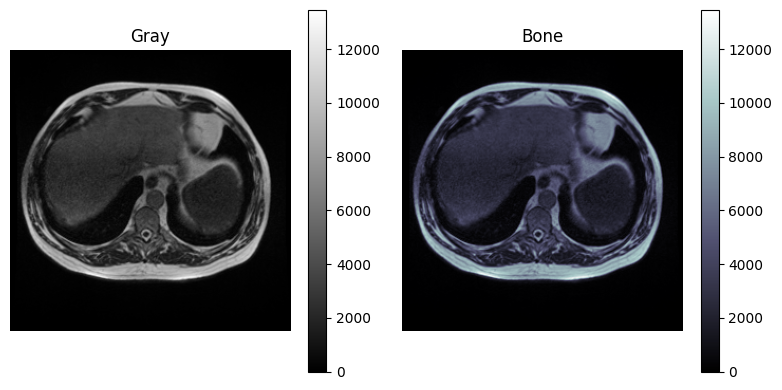

In [22]:
full_image_file_path = DIR_PATH + "train/case123/case123_day20/scans/slice_0065_266_266_1.50_1.50.png"

img = cv2.imread(full_image_file_path, cv2.IMREAD_UNCHANGED)
# default imread mode is IMREAD_COLOR which expects 8-bit 3 channel image, our input image is 16-bit grayscale which requires IMREAD_UNCHANGED

print(img.shape)
print(img)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Gray')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img, cmap='bone')
plt.title('Bone')
plt.axis('off')
plt.colorbar()

# while gray cmap is technically most correct for 16-bit grayscale image, using bone cmap from now on to enhance contrast visually

plt.tight_layout()
plt.show()

[[0.         0.         0.00141243 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(266, 266)
1.0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(266, 266)
255
[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
(266, 266)
255
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
(266, 266)
255


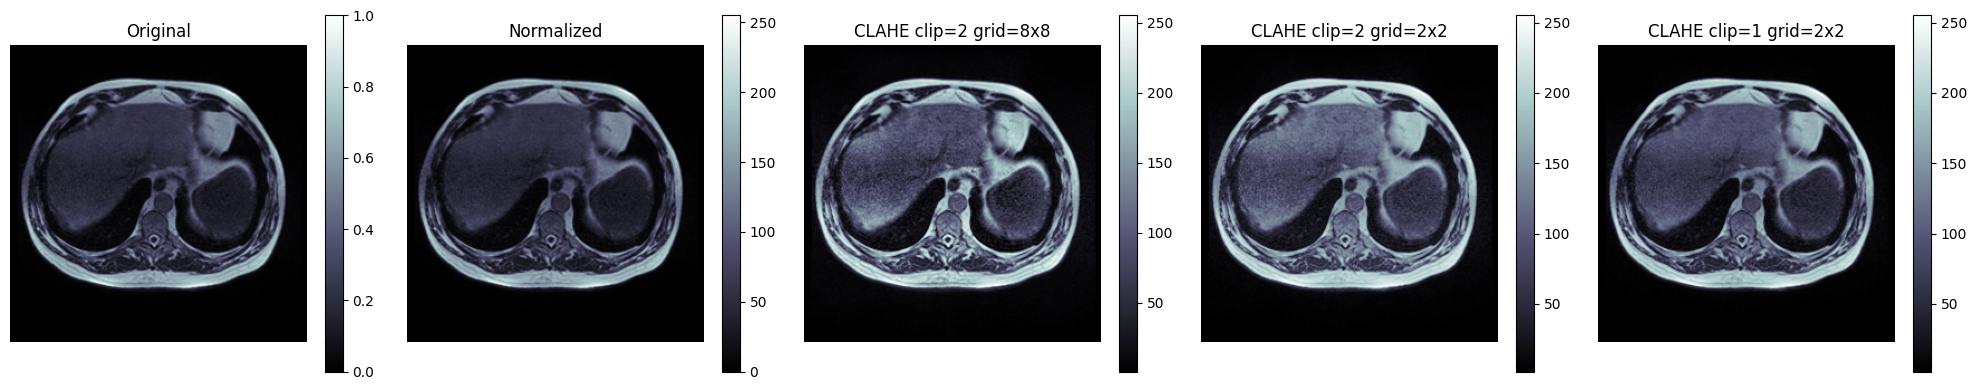

In [23]:
img = cv2.imread(full_image_file_path, cv2.IMREAD_UNCHANGED).astype('float32')

img_norm = img
mx = np.max(img)
if mx > 0:
    img_norm /= mx

print(img_norm)
print(img_norm.shape)
print(max([max(r) for r in img_norm]))

img_norm = (img_norm*255).astype(np.uint8)
print(img_norm)
print(img_norm.shape)
print(max([max(r) for r in img_norm]))

clahe1 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe2 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
clahe3 = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))

res1 = clahe1.apply(img_norm)
res2 = clahe2.apply(img_norm)
res3 = clahe3.apply(img_norm)

print(res1)
print(res1.shape)
print(max([max(r) for r in res1]))

print(res2)
print(res2.shape)
print(max([max(r) for r in res2]))

# Show results
plt.figure(figsize=(20, 4))
for i, (title, im) in enumerate(zip(['Original', 'Normalized', 'CLAHE clip=2 grid=8x8', 'CLAHE clip=2 grid=2x2', 'CLAHE clip=1 grid=2x2'], [img, img_norm, res1, res2, res3])):
    plt.subplot(1,5,i+1)
    plt.imshow(im, cmap='bone')
    plt.title(title)
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.show()

Based on the above figures, decided to use CLAHE clip=1 grid=2x2 for best visualization

## load_image

In [24]:
def load_image(id_, id_to_impath, load_resized=False):
    '''
    load_resized : if True, then precreated resized images will be loaded - used while training the model
    '''
    if load_resized:    
        image_path = RESIZED_IMAGE_DATASET_ROOT + os.path.relpath(id_to_impath[id_], DIR_PATH)
        image_path = os.path.splitext(image_path)[0] + '.npy'
        image = np.load(image_path)
    else:
        image = cv2.imread(id_to_impath[id_], cv2.IMREAD_UNCHANGED).astype('float32')  # convert from original 16-bit
        #print(f'Raw image {id_} min : {np.min(img)} max : {np.max(img)}')
        mx = np.max(image)
        if mx > 0:
            image /= mx
    return image

## display_image

In [25]:
def display_image(id_, id_dicts, pred_mask=None, apply_CLAHE=False,
                  show_orig_img=True, show_true_mask=True, show_pred_mask=False):
    
    img = load_image(id_, id_dicts['impath'])
    #print(f'load_image result {id_} min : {np.min(img)} max : {np.max(img)}')
    img = (img * 255).astype(np.uint8) # 0-255 range required for CLAHE. 
                                       # Using this in general to maintain consistency with the case where CLAHE is required
    #print(f'just before CLAHE {id_} min : {np.min(img)} max : {np.max(img)}')
    if apply_CLAHE:
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
        img = clahe.apply(img)
    
    mask = get_mask(id_, id_dicts)

    plt.figure(figsize=(9, 3))
    
    i = 1
    if show_orig_img:
        plt.subplot(1, 3, i)
        i += 1
        #print(f'just before imshow {id_} min : {np.min(img)} max : {np.max(img)}')
        plt.imshow(img, cmap='bone')
        plt.title(f'{id_} image')
        plt.axis('off')

    if show_true_mask:
        plt.subplot(1, 3, i)
        i += 1
        print(f'just before imshow {id_} min : {np.min(img)} max : {np.max(img)}')
        print(img.shape)
        plt.imshow(img, cmap='bone')
        plt.title('Image with true mask')
        plt.imshow(mask[..., 0], cmap=CMAP1)
        plt.imshow(mask[..., 1], cmap=CMAP2)
        plt.imshow(mask[..., 2], cmap=CMAP3)
        
        handles = [
            Rectangle((0, 0), 1, 1, color=CMAP1(1.0)),
            Rectangle((0, 0), 1, 1, color=CMAP2(1.0)),
            Rectangle((0, 0), 1, 1, color=CMAP3(1.0))
        ]
        labels = ['Large Bowel', 'Small Bowel', 'Stomach']
        plt.axis('off')
        plt.legend(handles, labels, bbox_to_anchor=(1.0, -0.4), loc='lower right', borderaxespad=0.)
    
    if show_pred_mask and pred_mask is not None:
        plt.subplot(1, 3, i)
        plt.imshow(img, cmap='bone')
        plt.title('Image with predicted mask')
        plt.imshow(pred_mask[..., 0], cmap=CMAP1)
        plt.imshow(pred_mask[..., 1], cmap=CMAP2)
        plt.imshow(pred_mask[..., 2], cmap=CMAP3)
        
        handles = [
            Rectangle((0, 0), 1, 1, color=CMAP1(1.0)),
            Rectangle((0, 0), 1, 1, color=CMAP2(1.0)),
            Rectangle((0, 0), 1, 1, color=CMAP3(1.0))
        ]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.axis('off')
        plt.legend(handles, labels, bbox_to_anchor=(1.0, -0.4), loc='lower right', borderaxespad=0.)
    
    
    plt.tight_layout()
    plt.show()  

just before imshow case131_day0_slice_0066 min : 0 max : 255
(310, 360)


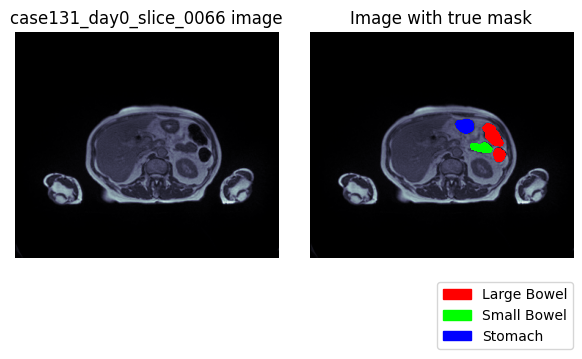

In [26]:
display_image('case131_day0_slice_0066', id_dicts)

just before imshow case131_day0_slice_0066 min : 2 max : 255
(310, 360)


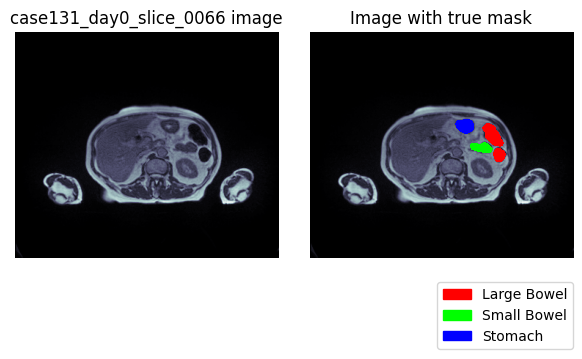

In [27]:
display_image('case131_day0_slice_0066', id_dicts, apply_CLAHE=True)

In [28]:
# # testing pred_mask display using true mask
# display_image('case131_day0_slice_0066', id_dicts, pred_mask=get_mask('case131_day0_slice_0066', id_dicts),
#               show_pred_mask=True, apply_CLAHE=True)

just before imshow case123_day20_slice_0065 min : 2 max : 255
(266, 266)


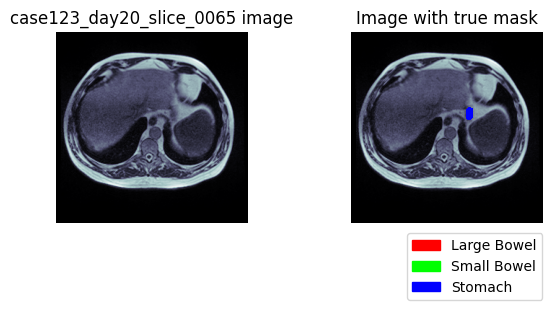

In [29]:
# example image with only stomach segment
display_image('case123_day20_slice_0065', id_dicts, apply_CLAHE=True)

just before imshow case123_day20_slice_0001 min : 2 max : 255
(266, 266)


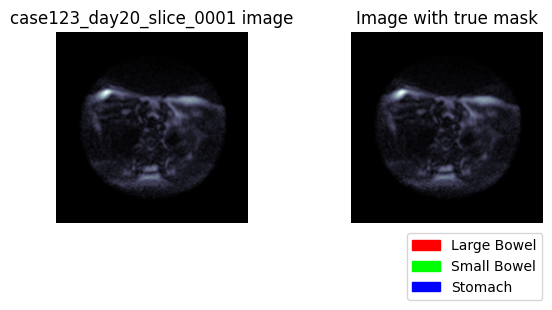

In [30]:
# example image without any segment
display_image('case123_day20_slice_0001', id_dicts, apply_CLAHE=True)

We see that the max value in the raw image for the 3 images shown previously are significantly different : 605, 13452, 2546

## display_multiple_slices

In [31]:
def display_multiple_slices(id_array, id_dicts, apply_CLAHE=False,
                            show_pred_mask=False, pred_mask_array=None):

    '''
    id_array : an array of ids like case123_day20_slice_0001
    id_dicts : dict of id_mapping dicts - allowed keys : impath, shape, rle
    apply_CLAHE : whether or not to apply CLAHE
    show_pred_mask : if this parameter is False, then true mask will be shown
                     if it is True, masks from pred_mask_array will be shown
    pred_mask_array : array of prediction masks
    '''

    l = len(id_array)
    rows = np.ceil(l/5).astype(int)
    max_cols = 5

    plt.figure(figsize=(max_cols*3, rows*3))

    for i in range(l):

        id_ = id_array[i]
        
        img = cv2.imread(id_dicts['impath'][id_], cv2.IMREAD_UNCHANGED).astype('float32')
        mx = np.max(img)
        if mx > 0:
            img /= mx

        if apply_CLAHE:
            clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
            img = (img * 255).astype(np.uint8)
            img = clahe3.apply(img)

        if show_pred_mask and pred_mask_array is not None:
            mask = pred_mask_array[i]
        else:
            mask = get_mask(id_, id_dicts)

        plt.subplot(rows, max_cols, i+1)
        plt.imshow(img, cmap='bone')
        plt.title(id_)
        plt.imshow(mask[..., 0], cmap=CMAP1)
        plt.imshow(mask[..., 1], cmap=CMAP2)
        plt.imshow(mask[..., 2], cmap=CMAP3)
        plt.axis('off')

        if i == 0:
            handles = [
                Rectangle((0, 0), 1, 1, color=CMAP1(1.0)),
                Rectangle((0, 0), 1, 1, color=CMAP2(1.0)),
                Rectangle((0, 0), 1, 1, color=CMAP3(1.0))
            ]
            labels = ['Large Bowel', 'Small Bowel', 'Stomach']
        
            plt.legend(handles, labels, bbox_to_anchor=(0.0, 1.5), loc='upper left', borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()  

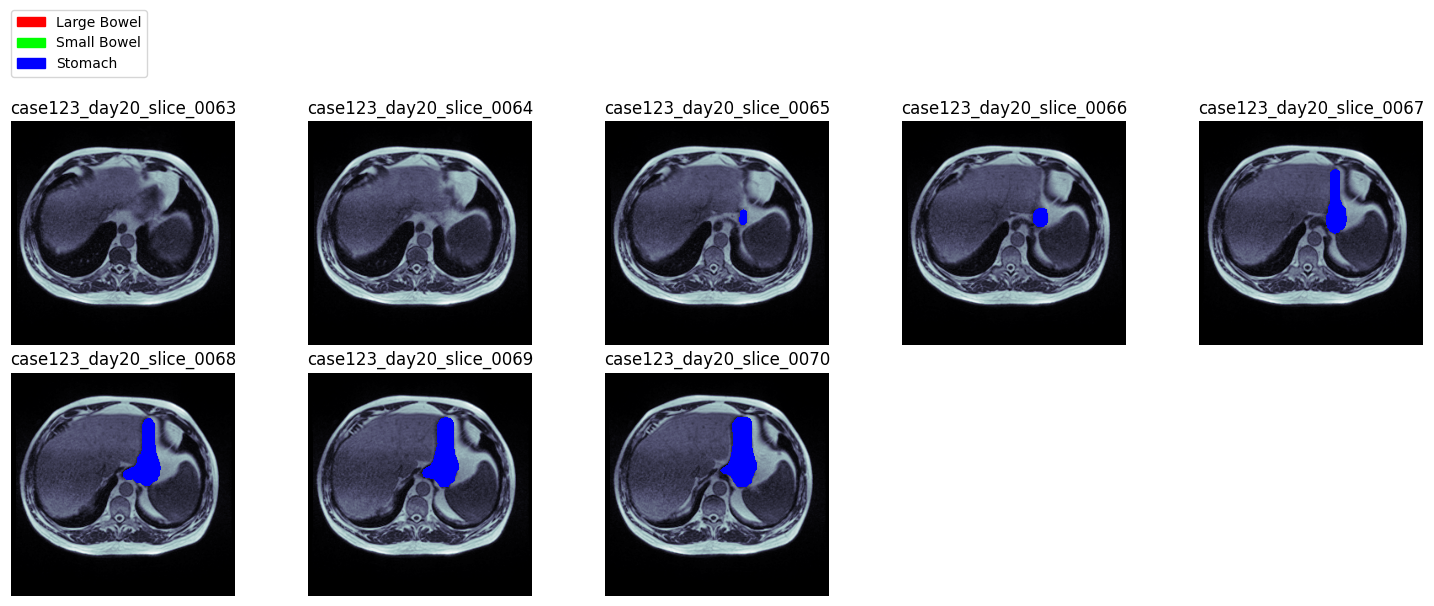

In [32]:
# using the below data to visualize change in segmentation mask across different slices
# data.query("case == 123 and day == 20 and slice >= 63 and slice <= 70")
display_multiple_slices(data.query("case == 123 and day == 20 and slice >= 63 and slice <= 70").id.unique(), 
                        id_dicts, apply_CLAHE=True)

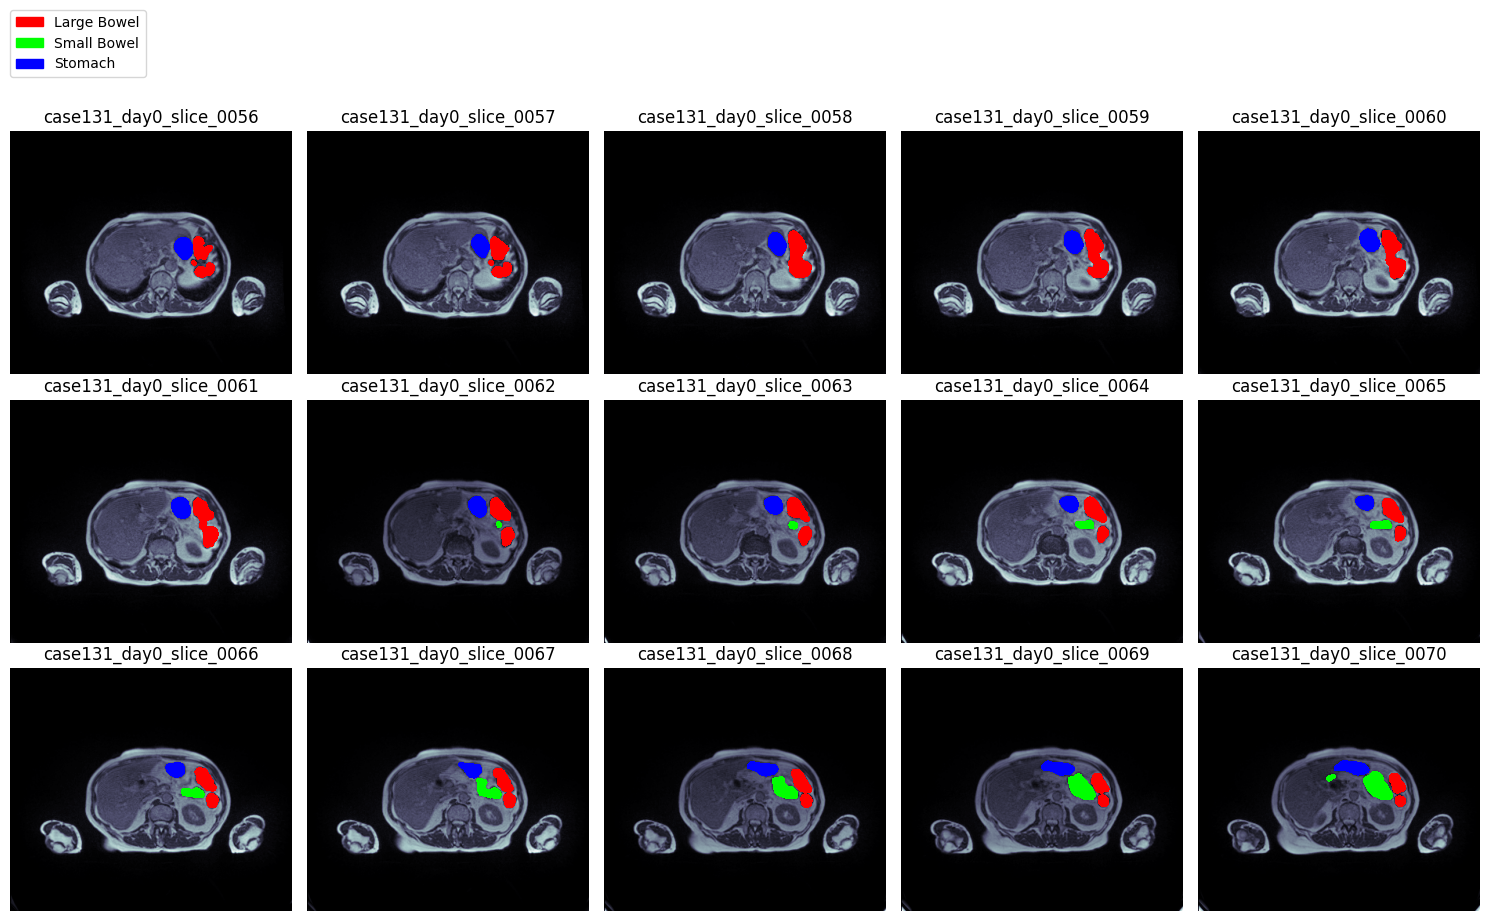

In [33]:
# using the below data to visualize change in segmentation mask across different slices - for a case where all masks are present
# data.query("case == 131 and day == 0 and slice > 60 and slice <= 70")
display_multiple_slices(data.query("case == 131 and day == 0 and slice > 55 and slice <= 70").id.unique(), 
                        id_dicts, apply_CLAHE=True)

## EDA

In [34]:
data.loc[data.segmentation.isna(), :]

id        class segmentation  case  day  slice  \
0       case123_day20_slice_0001  large_bowel          NaN   123   20      1   
1       case123_day20_slice_0001  small_bowel          NaN   123   20      1   
2       case123_day20_slice_0001      stomach          NaN   123   20      1   
3       case123_day20_slice_0002  large_bowel          NaN   123   20      2   
4       case123_day20_slice_0002  small_bowel          NaN   123   20      2   
...                          ...          ...          ...   ...  ...    ...   
115483    case30_day0_slice_0143  small_bowel          NaN    30    0    143   
115484    case30_day0_slice_0143      stomach          NaN    30    0    143   
115485    case30_day0_slice_0144  large_bowel          NaN    30    0    144   
115486    case30_day0_slice_0144  small_bowel          NaN    30    0    144   
115487    case30_day0_slice_0144      stomach          NaN    30    0    144   

                                                                                                                     image_path  \
0       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png   
1       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png   
2       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png   
3       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png   
4       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png   
...                                                                                                                         ...   
115483     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png   
115484     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png   
115485     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png   
115486     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png   
115487     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png   

        slice_w  slice_h  px_w  px_h  
0           266      266   1.5   1.5  
1           266      266   1.5   1.5  
2           266      266   1.5   1.5  
3           266      266   1.5   1.5  
4           266      266   1.5   1.5  
...         ...      ...   ...   ...  
115483      266      266   1.5   1.5  
115484      266      266   1.5   1.5  
115485      266      266   1.5   1.5  
115486      266      266   1.5   1.5  
115487      266      266   1.5   1.5  

[81575 rows x 11 columns]

In [35]:
# How many missing values
data.isna().sum()

id                  0
class               0
segmentation    81575
case                0
day                 0
slice               0
image_path          0
slice_w             0
slice_h             0
px_w                0
px_h                0
dtype: int64

Only segmentation column contains NaN / missing values

In [36]:
print(f'Num cases : {len(data.case.unique())} \
        Num unique days : {len(data.day.unique())}   \
        Num unique slices : {len(data.slice.unique())}')

Num cases : 85         Num unique days : 35           Num unique slices : 144


In [37]:
# proportion of different slice sizes
count_df = data[['id', 'slice_w', 'slice_h']].drop_duplicates()[['slice_w', 'slice_h']].value_counts().reset_index(name='count')
count_df['percent'] = count_df['count']*100 / sum(count_df['count'])
print(sum(count_df['count']))
count_df

38496


slice_w  slice_h  count    percent
0      266      266  25920  67.331671
1      360      310  11232  29.177057
2      276      276   1200   3.117207
3      234      234    144   0.374065

In [38]:
# proportion of different pixel sizes
count_df = data[['id', 'px_w', 'px_h']].drop_duplicates()[['px_w', 'px_h']].value_counts().reset_index(name='count')
count_df['percent'] = count_df['count']*100 / sum(count_df['count'])
print(sum(count_df['count']))
count_df

38496


px_w  px_h  count    percent
0  1.50  1.50  37296  96.882793
1  1.63  1.63   1200   3.117207

In both of the 2 cells above, after dropping duplicates, there will be only single entry corresponding to a specific image path.
Hence the sum of counts is equal to the path_df length (or 1/3 of data length).

We see that all the slices (except 360x310) and pixels are squares (same width and height).
266x266 is the most frequent slice size - 67%, followed by 360x310 - 29%. 

We could resize to 256x256 or 288x288 image size for training the model (UNet model expects input sizes in multiples of 32), and monitor the performance in 360x310 sliced images to verify if slightly larger size combined with different width-height causes issues

case  num_days
0     36         6
1     35         5
2     43         5
3     18         5
4     85         5
..   ...       ...
80   115         1
81    53         1
82    91         1
83    58         1
84   102         1

[85 rows x 2 columns]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


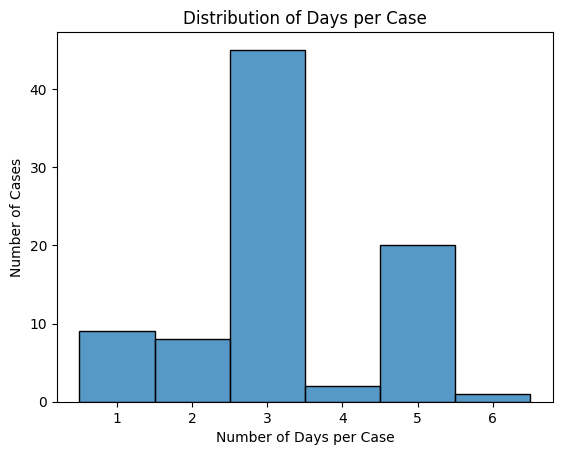

In [39]:
day_dist = data[['case', 'day']].drop_duplicates()['case'].value_counts().reset_index(name='num_days')

display(day_dist)

sns.histplot(data=day_dist, x='num_days', bins=range(1, day_dist['num_days'].max() + 1), discrete=True)
plt.xlabel('Number of Days per Case')
plt.ylabel('Number of Cases')
plt.title('Distribution of Days per Case')
plt.show()

85 unique cases with most cases having 3 days data

case  day  num_slices
0     156   11         144
1       2    1         144
2       2    2         144
3       2    3         144
4       2    4         144
..    ...  ...         ...
269    35   12          80
270    35   13          80
271    35   15          80
272    35   18          80
273   131   15          80

[274 rows x 3 columns]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


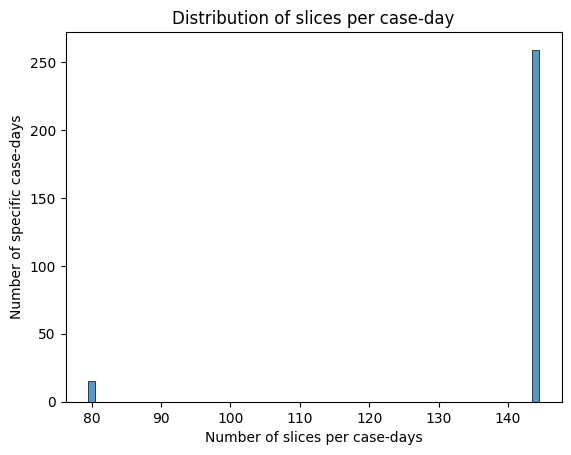

num_slices
144    259
80      15
Name: count, dtype: int64

In [40]:
slice_dist = data[['case', 'day', 'slice']].drop_duplicates()[['case', 'day']].value_counts().reset_index(name='num_slices')
display(slice_dist)

sns.histplot(data=slice_dist, x='num_slices', bins=range(1, slice_dist['num_slices'].max() + 1), discrete=True)
plt.xlabel('Number of slices per case-days')
plt.ylabel('Number of specific case-days')
plt.title('Distribution of slices per case-day')
plt.show()

display(slice_dist.num_slices.value_counts())

274 unique case-days having mostly 144 slices and few of them with 80 slices

In [41]:
slice_dist.loc[slice_dist.num_slices == 80, :]

case  day  num_slices
259    34    0          80
260   146   25          80
261   117   16          80
262   117   17          80
263   118    0          80
264   117   13          80
265   117   15          80
266    89   21          80
267    34   15          80
268    34   16          80
269    35   12          80
270    35   13          80
271    35   15          80
272    35   18          80
273   131   15          80

In [42]:
case_day_slice_df = data[['case', 'day', 'slice', 'slice_w', 'slice_h']].drop_duplicates()
case_day_slice_df.merge(case_day_slice_df, on=['case', 'day']).query("(slice_w_x != slice_w_y) | (slice_h_x != slice_h_y)")

Empty DataFrame
Columns: [case, day, slice_x, slice_w_x, slice_h_x, slice_y, slice_w_y, slice_h_y]
Index: []

All slices within a specific case-day have the same slice_w and slice_h

In [43]:
case_day_slice_df = data[['case', 'day', 'slice', 'slice_w', 'slice_h']].drop_duplicates()
case_day_slice_df.merge(case_day_slice_df, on=['case']).query("(slice_w_x != slice_w_y) | (slice_h_x != slice_h_y)")

case  day_x  slice_x  slice_w_x  slice_h_x  day_y  slice_y  \
1078416    139     18        1        266        266      0        1   
1078417    139     18        1        266        266      0        2   
1078418    139     18        1        266        266      0        3   
1078419    139     18        1        266        266      0        4   
1078420    139     18        1        266        266      0        5   
...        ...    ...      ...        ...        ...    ...      ...   
18706027    41     25      144        266        266      0      140   
18706028    41     25      144        266        266      0      141   
18706029    41     25      144        266        266      0      142   
18706030    41     25      144        266        266      0      143   
18706031    41     25      144        266        266      0      144   

          slice_w_y  slice_h_y  
1078416         234        234  
1078417         234        234  
1078418         234        234  
1078419         234        234  
1078420         234        234  
...             ...        ...  
18706027        360        310  
18706028        360        310  
18706029        360        310  
18706030        360        310  
18706031        360        310  

[1912320 rows x 9 columns]

But within a specific case multiple days can have different slice_w and slice_h

In [44]:
case_day_slice_df = data[['case', 'day', 'slice', 'px_w', 'px_h']].drop_duplicates()
case_day_slice_df.merge(case_day_slice_df, on=['case', 'day']).query("(px_w_x != px_w_y) | (px_h_x != px_h_y)")

Empty DataFrame
Columns: [case, day, slice_x, px_w_x, px_h_x, slice_y, px_w_y, px_h_y]
Index: []

In [45]:
case_day_slice_df = data[['case', 'day', 'slice', 'px_w', 'px_h']].drop_duplicates()
case_day_slice_df.merge(case_day_slice_df, on=['case']).query("(px_w_x != px_w_y) | (px_h_x != px_h_y)")

case  day_x  slice_x  px_w_x  px_h_x  day_y  slice_y  px_w_y  px_h_y
2509136    118      0        1    1.63    1.63     16        1    1.50    1.50
2509137    118      0        1    1.63    1.63     16        2    1.50    1.50
2509138    118      0        1    1.63    1.63     16        3    1.50    1.50
2509139    118      0        1    1.63    1.63     16        4    1.50    1.50
2509140    118      0        1    1.63    1.63     16        5    1.50    1.50
...        ...    ...      ...     ...     ...    ...      ...     ...     ...
16030939   146     24      144    1.50    1.50     25       76    1.63    1.63
16030940   146     24      144    1.50    1.50     25       77    1.63    1.63
16030941   146     24      144    1.50    1.50     25       78    1.63    1.63
16030942   146     24      144    1.50    1.50     25       79    1.63    1.63
16030943   146     24      144    1.50    1.50     25       80    1.63    1.63

[460800 rows x 9 columns]

Same for pixel sizes. All slices within specific case-day have same pixel size, but different days within same case can have different pixel size.

## EDA - missing masks

In [46]:
num_missing_seg_masks = data.segmentation.isna().sum() 
print(f'Missing Seg Mask \n count = {num_missing_seg_masks}\n percentage = {num_missing_seg_masks/len(data)*100}')

Missing Seg Mask 
 count = 81575
 percentage = 70.63504433361042


Approximately 70% of entries have missing segmentation masks

In [47]:
data['class'].value_counts()

class
large_bowel    38496
small_bowel    38496
stomach        38496
Name: count, dtype: int64

As expected (previously seen that number of rows in data df is 3x that of path_df), all 3 segmentation classes have equal number of entries.

class  count    percent
0  large_bowel  24411  63.411783
1  small_bowel  27295  70.903470
2      stomach  29869  77.589879

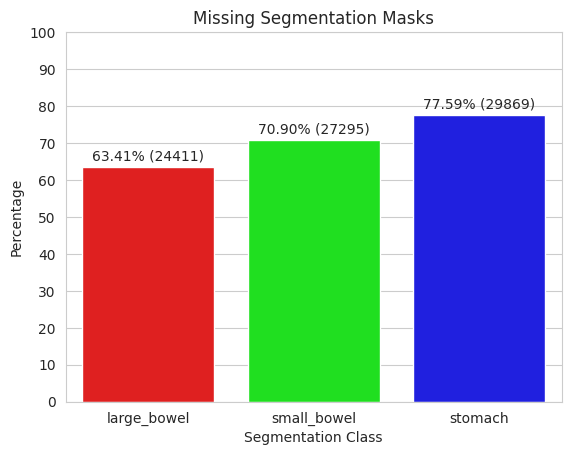

In [48]:
na_counts = (
    data.groupby('class')['segmentation']
    .apply(lambda s: s.isna().sum())
    .reset_index(name='count')
)
na_counts['percent'] = 100 * na_counts['count'] / data.groupby('class')['segmentation'].size().values

display(na_counts)

sns.set_style("whitegrid") 
ax = sns.barplot(data=na_counts, x='class', y='percent', palette=[CMAP1(1.0), CMAP2(1.0), CMAP3(1.0)])

for i, row in na_counts.iterrows():
    ax.text(i, row['percent'] + 1,  # position just above the bar
            f"{row['percent']:.2f}% ({row['count']})",
            ha='center', va='bottom', fontsize=10)

plt.ylabel('Percentage')
plt.xlabel('Segmentation Class')
plt.title('Missing Segmentation Masks')
plt.yticks(range(0, 105, 10))
plt.show()

case  day        class  count
228    43   26  large_bowel    144
340    74   18  small_bowel    131
761   146    0      stomach    129
334    74   13  small_bowel    129
308    65   25      stomach    128
..    ...  ...          ...    ...
534   117   16  large_bowel     27
642   131   15  large_bowel     26
537   117   17  large_bowel     25
432    89   21  large_bowel     25
531   117   15  large_bowel     24

[822 rows x 4 columns]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


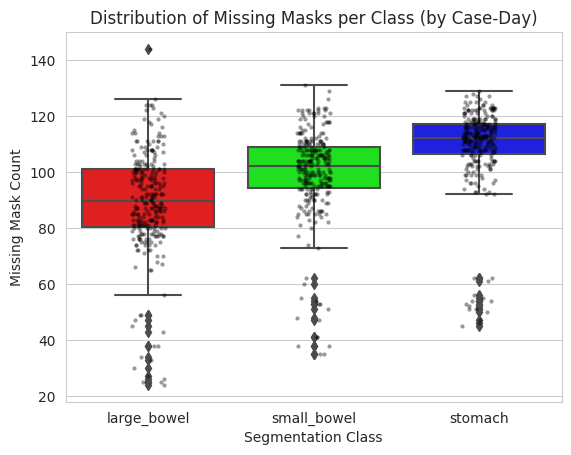

In [49]:
case_day_seg_missing = (
     data[['case', 'day', 'class', 'segmentation']]
     .groupby(['case', 'day', 'class'])['segmentation']
     .apply(lambda s: s.isna().sum())
     .reset_index(name='count').sort_values(by='count', ascending=False)
)
display(case_day_seg_missing)


# sns.set_style("whitegrid") 
# ax = sns.barplot(data=na_counts, x='class', y='percent', palette=[CMAP1(1.0), CMAP2(1.0), CMAP3(1.0)])

# for i, row in na_counts.iterrows():
#     ax.text(i, row['percent'] + 1,  # position just above the bar
#             f"{row['percent']:.2f}% ({row['count']})",
#             ha='center', va='bottom', fontsize=10)

# plt.ylabel('Percentage')
# plt.xlabel('Segmentation Class')
# plt.title('Missing Segmentation Masks')
# plt.yticks(range(0, 105, 10))
# plt.show()

sns.boxplot(data=case_day_seg_missing, x='class', y='count', palette=[CMAP1(1.0), CMAP2(1.0), CMAP3(1.0)])
sns.stripplot(data=case_day_seg_missing, x='class', y='count', color='black', size=3, jitter=True, alpha=0.4)
plt.ylabel('Missing Mask Count')
plt.xlabel('Segmentation Class')
plt.title('Distribution of Missing Masks per Class (by Case-Day)')
plt.show()

Only 1 case-day seems to have all 144 slices missing large_bowel (case 43 - day 26). Lets visualize those slices.

In [50]:
# display_multiple_slices(data.query("case == 43 and day == 26").id.unique(), 
#                         id_dicts, apply_CLAHE=True)

just before imshow case43_day26_slice_0057 min : 2 max : 255
(266, 266)


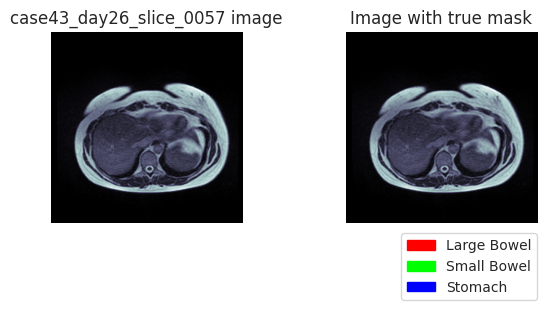

just before imshow case43_day26_slice_0058 min : 2 max : 255
(266, 266)


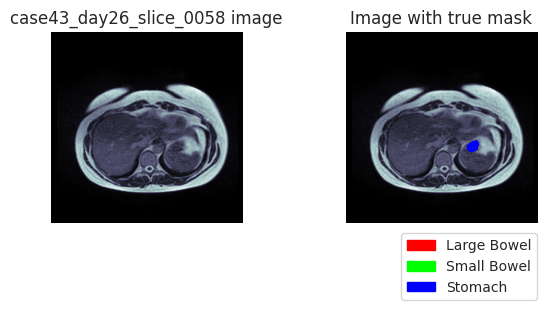

just before imshow case43_day26_slice_0121 min : 1 max : 255
(266, 266)


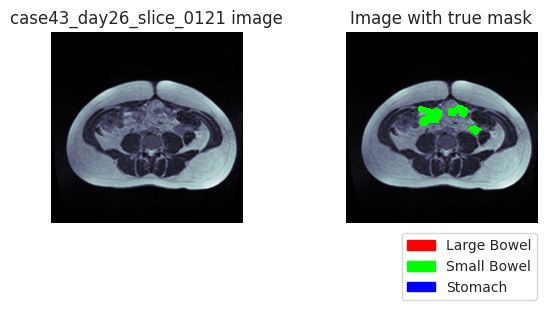

just before imshow case43_day26_slice_0122 min : 1 max : 255
(266, 266)


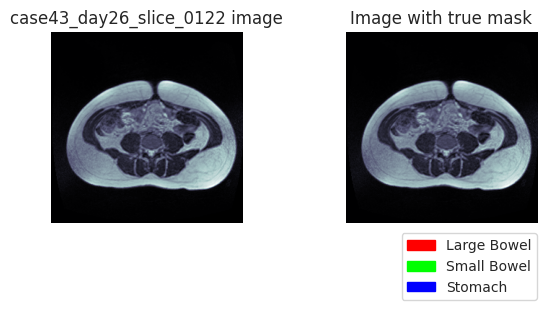

In [51]:
#visualizing the original image and image with true mask for border slices where segmentation classes just start appearing/disapperaing
display_image('case43_day26_slice_0057', id_dicts, apply_CLAHE=True)
display_image('case43_day26_slice_0058', id_dicts, apply_CLAHE=True)
display_image('case43_day26_slice_0121', id_dicts, apply_CLAHE=True)
display_image('case43_day26_slice_0122', id_dicts, apply_CLAHE=True)

day 15 for case 117 has the least number of missing. Lets visualize that too

In [52]:
# display_multiple_slices(data.query("case == 117 and day == 15").id.unique(), 
#                         id_dicts, apply_CLAHE=True)

just before imshow case117_day15_slice_0009 min : 2 max : 255
(276, 276)


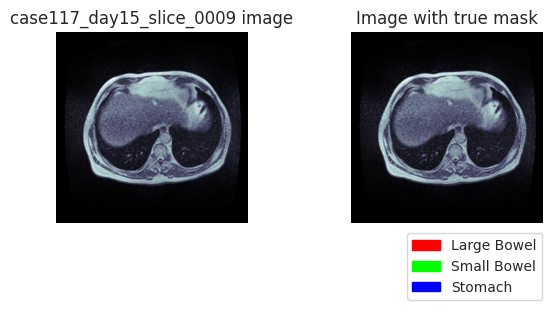

just before imshow case117_day15_slice_0010 min : 2 max : 255
(276, 276)


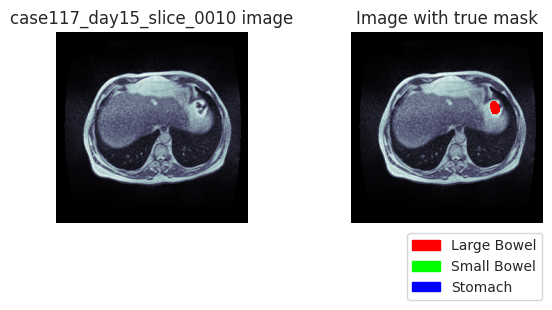

just before imshow case117_day15_slice_0065 min : 2 max : 255
(276, 276)


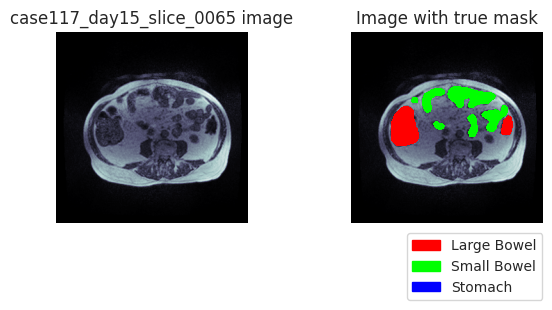

just before imshow case117_day15_slice_0066 min : 1 max : 255
(276, 276)


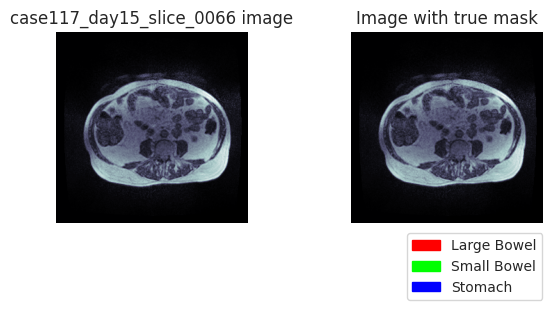

In [53]:
#visualizing the original image and image with true mask for border slices where segmentation classes just start appearing/disapperaing
display_image('case117_day15_slice_0009', id_dicts, apply_CLAHE=True)
display_image('case117_day15_slice_0010', id_dicts, apply_CLAHE=True)
display_image('case117_day15_slice_0065', id_dicts, apply_CLAHE=True)
display_image('case117_day15_slice_0066', id_dicts, apply_CLAHE=True)

The general structure of all slices per day seem to be that only the middle slices have the segmentation classes visible.

# Precompute masks

In [54]:
# if SAVE_MASKS:
#     for i, (k, v) in enumerate(idclass_to_rle.items()):
#         if i == 5:   # stop after 5
#             break
#         print(k, v)

In [55]:
def save_mask(id_, id_dicts):
    mask = get_mask(id_, id_dicts)
    image_path = id_dicts['impath'][id_]
    rel_path = os.path.relpath(image_path, DIR_PATH)
    mask_path = os.path.splitext(rel_path)[0] + '.npy'
    #print(mask_path)
    mask_dir = mask_path.rsplit('/', 1)[0]
    os.makedirs(mask_dir, exist_ok = True)
    np.save(mask_path, mask)


# save_mask('case117_day15_slice_0065', id_dicts)
# mask = np.load('/kaggle/working/train/case117/case117_day15/scans/slice_0065_276_276_1.63_1.63.npy')
# mask.shape

In [56]:
if SAVE_MASKS:
    for id_ in tqdm(data.id.unique()):
        save_mask(id_, id_dicts)

# Precompute resized masks and images

In [57]:
resize_transform = A.Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1], 
                            interpolation = cv2.INTER_NEAREST,
                            mask_interpolation = cv2.INTER_NEAREST,)

def save_resized(id_, id_dicts):
    mask = get_mask(id_, id_dicts)
    image = load_image(id_, id_dicts['impath'])

    result = resize_transform(image = image, mask = mask)
    image, mask = result['image'], result['mask']

    image_orig_path = id_dicts['impath'][id_]
    rel_path = os.path.relpath(image_orig_path, DIR_PATH)
    
    mask_path = 'mask_resized/' + os.path.splitext(rel_path)[0] + '.npy'
    mask_dir = mask_path.rsplit('/', 1)[0]
    os.makedirs(mask_dir, exist_ok = True)
    np.save(mask_path, mask)

    image_path = 'image_resized/' + os.path.splitext(rel_path)[0] + '.npy'
    image_dir = image_path.rsplit('/', 1)[0]
    os.makedirs(image_dir, exist_ok = True)
    np.save(image_path, image)

if SAVE_RESIZED:
    for id_ in tqdm(data.id.unique()):
        save_resized(id_, id_dicts)

# Train validation split

The competition data description mentions that there are some cases with early days in train and later days in test, and some other cases where entirety of case is in train or test.

We could split cases into 2 - set1, set2 where set1 could be used for partially unseen cases and set2 for wholly unseen cases.
set1 could be created as  : for each case 80% of early days in train, and 20% later days in test
set2 could be created as  : 80% of cases in train and 20% in test

Also, in both these approaches it would be good to incorporate empty segmentation mask percentage.

But the number of days in different cases is different, and as we have seen previously, there are large number of cases with 1 or 2 or 3 days. This would make set1 based approach more complicated. So for now, we'll rely on only set2 based approach.

In [58]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
index_train, index_valid = list(sgkf.split(data.id, data.segmentation.isna(), data.case))[0]

In [59]:
len(index_train), len(index_valid)

(89664, 25824)

In [60]:
data_train = data.iloc[index_train, :]
data_valid = data.iloc[index_valid, :]

In [61]:
data_train

id        class segmentation  case  day  slice  \
0       case123_day20_slice_0001  large_bowel          NaN   123   20      1   
1       case123_day20_slice_0001  small_bowel          NaN   123   20      1   
2       case123_day20_slice_0001      stomach          NaN   123   20      1   
3       case123_day20_slice_0002  large_bowel          NaN   123   20      2   
4       case123_day20_slice_0002  small_bowel          NaN   123   20      2   
...                          ...          ...          ...   ...  ...    ...   
115483    case30_day0_slice_0143  small_bowel          NaN    30    0    143   
115484    case30_day0_slice_0143      stomach          NaN    30    0    143   
115485    case30_day0_slice_0144  large_bowel          NaN    30    0    144   
115486    case30_day0_slice_0144  small_bowel          NaN    30    0    144   
115487    case30_day0_slice_0144      stomach          NaN    30    0    144   

                                                                                                                     image_path  \
0       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png   
1       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png   
2       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png   
3       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png   
4       /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png   
...                                                                                                                         ...   
115483     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png   
115484     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png   
115485     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png   
115486     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png   
115487     /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png   

        slice_w  slice_h  px_w  px_h  
0           266      266   1.5   1.5  
1           266      266   1.5   1.5  
2           266      266   1.5   1.5  
3           266      266   1.5   1.5  
4           266      266   1.5   1.5  
...         ...      ...   ...   ...  
115483      266      266   1.5   1.5  
115484      266      266   1.5   1.5  
115485      266      266   1.5   1.5  
115486      266      266   1.5   1.5  
115487      266      266   1.5   1.5  

[89664 rows x 11 columns]

In [62]:
data_valid

id        class segmentation  case  day  slice  \
3888    case129_day20_slice_0001  large_bowel          NaN   129   20      1   
3889    case129_day20_slice_0001  small_bowel          NaN   129   20      1   
3890    case129_day20_slice_0001      stomach          NaN   129   20      1   
3891    case129_day20_slice_0002  large_bowel          NaN   129   20      2   
3892    case129_day20_slice_0002  small_bowel          NaN   129   20      2   
...                          ...          ...          ...   ...  ...    ...   
109003   case41_day25_slice_0143  small_bowel          NaN    41   25    143   
109004   case41_day25_slice_0143      stomach          NaN    41   25    143   
109005   case41_day25_slice_0144  large_bowel          NaN    41   25    144   
109006   case41_day25_slice_0144  small_bowel          NaN    41   25    144   
109007   case41_day25_slice_0144      stomach          NaN    41   25    144   

                                                                                                                     image_path  \
3888    /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case129/case129_day20/scans/slice_0001_360_310_1.50_1.50.png   
3889    /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case129/case129_day20/scans/slice_0001_360_310_1.50_1.50.png   
3890    /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case129/case129_day20/scans/slice_0001_360_310_1.50_1.50.png   
3891    /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case129/case129_day20/scans/slice_0002_360_310_1.50_1.50.png   
3892    /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case129/case129_day20/scans/slice_0002_360_310_1.50_1.50.png   
...                                                                                                                         ...   
109003    /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case41/case41_day25/scans/slice_0143_266_266_1.50_1.50.png   
109004    /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case41/case41_day25/scans/slice_0143_266_266_1.50_1.50.png   
109005    /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case41/case41_day25/scans/slice_0144_266_266_1.50_1.50.png   
109006    /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case41/case41_day25/scans/slice_0144_266_266_1.50_1.50.png   
109007    /kaggle/input/uw-madison-gi-tract-image-segmentation/train/case41/case41_day25/scans/slice_0144_266_266_1.50_1.50.png   

        slice_w  slice_h  px_w  px_h  
3888        360      310   1.5   1.5  
3889        360      310   1.5   1.5  
3890        360      310   1.5   1.5  
3891        360      310   1.5   1.5  
3892        360      310   1.5   1.5  
...         ...      ...   ...   ...  
109003      266      266   1.5   1.5  
109004      266      266   1.5   1.5  
109005      266      266   1.5   1.5  
109006      266      266   1.5   1.5  
109007      266      266   1.5   1.5  

[25824 rows x 11 columns]

## Using data subset
To start off with, we'll use a smaller dataset by considering around 1/10 th of the cases

In [63]:
print(len(data_train.case.unique()), len(data_valid.case.unique()))

67 18


In [64]:
data_train_sub = data_train.loc[data_train.case.isin(data_train.case.unique()[:11]), :]
data_valid_sub = data_valid.loc[data_valid.case.isin(data_valid.case.unique()[:2]), :]

print(len(data_train_sub), len(data_valid_sub), len(data_train_sub)/len(data_valid_sub))

# Note : 11, 2 numbers obtained by manually trying numbers 
#              with 18/10 ~ 2 for valid and such that train len/valid len ~ 4 similar to 4 splits for train and 1 split for valid

13824 3456 4.0


In [65]:
missing_masks_train = data_train_sub.segmentation.isna().sum() 
missing_masks_valid = data_valid_sub.segmentation.isna().sum() 
print(missing_masks_train, missing_masks_train*100/len(data_train_sub))
print(missing_masks_valid, missing_masks_valid*100/len(data_valid_sub))

9780 70.74652777777777
2356 68.17129629629629


approximately similar

In [66]:
na_counts_train = (
    data_train_sub.groupby('class')['segmentation']
    .apply(lambda s: s.isna().sum())
    .reset_index(name='count')
)
na_counts_train['percent'] = 100 * na_counts_train['count'] / data_train_sub.groupby('class')['segmentation'].size().values

display(na_counts_train)


na_counts_valid = (
    data_valid_sub.groupby('class')['segmentation']
    .apply(lambda s: s.isna().sum())
    .reset_index(name='count')
)
na_counts_valid['percent'] = 100 * na_counts_valid['count'] / data_valid_sub.groupby('class')['segmentation'].size().values

display(na_counts_valid)

class  count    percent
0  large_bowel   2975  64.561632
1  small_bowel   3349  72.677951
2      stomach   3456  75.000000

class  count    percent
0  large_bowel    653  56.684028
1  small_bowel    821  71.267361
2      stomach    882  76.562500

roughly same with some difference in large_bowel missing percentage

In [67]:
data_train_sub = data_train_sub.reset_index(drop=True)

In [68]:
data_valid_sub = data_valid_sub.reset_index(drop=True)

# Data Augmentation

In [69]:
transform_train = A.ReplayCompose([
    # A.HorizontalFlip(p = 0.25),
    A.Normalize(mean = IMAGE_NORMALIZE_MEAN, std = IMAGE_NORMALIZE_SD, max_pixel_value = 1.0),
    A.ToTensorV2(transpose_mask = True),
])

transform_valid = A.Compose([
    A.Normalize(mean = IMAGE_NORMALIZE_MEAN, std = IMAGE_NORMALIZE_SD, max_pixel_value = 1.0),
    A.ToTensorV2(transpose_mask = True),
])

In [70]:
def create_caseday_replay_transform(df, transforms):
    caseday_replay_transform = {}
    h, w = IMAGE_RESIZE
    dummy_image = np.zeros((h, w, 3), dtype=np.float32)
    dummy_mask  = np.zeros((h, w), dtype=np.uint8)

    for (case, day), group in df.groupby(['case', 'day']):
        augmented = transforms(image=dummy_image, mask=dummy_mask)
        caseday_str = f'case{case}_day{day}'
        caseday_replay_transform[caseday_str] = augmented['replay']

    return caseday_replay_transform

# Dataset

In [71]:
# # intensity ranges of images are inconsistent as seen in this cell's output shown commented
# # so it is better to use per image scaling while loading images instead of globally normalizing by 65535(since image is 16 bit)

# def read_image(id_, id_to_impath):
#   img = cv2.imread(id_to_impath[id_], cv2.IMREAD_UNCHANGED)
#   return img

# sample_image = read_image('case123_day0_slice_0001', id_to_impath)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case123_day0_slice_0002', id_to_impath)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case123_day0_slice_0003', id_to_impath)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case123_day20_slice_0001', id_to_impath)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case123_day22_slice_0001', id_to_impath)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case42_day0_slice_0001', id_to_impath)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case42_day17_slice_0001', id_to_impath)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case42_day19_slice_0001', id_to_impath)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case129_day0_slice_0001', id_to_impath)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case129_day20_slice_0001', id_to_impath)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case129_day22_slice_0001', id_to_impath)
# print(np.min(sample_image), np.max(sample_image))

# # 0 3621
# # 0 3553
# # 0 2822
# # 0 2546
# # 0 6886
# # 0 2322
# # 0 1332
# # 0 4326
# # 0 521
# # 0 363
# # 0 200

In [72]:
class GITractDataset(Dataset):
    def __init__(self, df, dataset_type, transforms=None, load_saved_masks=LOAD_SAVED_MASKS, load_resized=LOAD_RESIZED):
        '''
        dataset_type : One of 'train, 'valid', 'test'
        '''
        self.id_ = df.id.unique()

        self.dataset_type = dataset_type
        self.transforms = transforms

        id_to_impath = dict(zip(df.id, df.image_path))
        self.id_dicts = {'impath': id_to_impath}

        id_to_shape = None
        idclass_to_rle = None
        
        if not (load_saved_masks or load_resized) or self.dataset_type == 'test':
            id_to_shape = dict(zip(df.id, zip(df.slice_h, df.slice_w)))
            
        if not (load_saved_masks or load_resized) and self.dataset_type != 'test':
            idclass_to_rle = {
                (id_, class_): seg
                for id_, class_, seg in zip(df.id, df['class'], df.segmentation)
                if pd.notna(seg)
            }

        self.id_dicts['shape'] = id_to_shape
        self.id_dicts['rle'] = idclass_to_rle

        self.load_resized = load_resized

        # note : can't use set of either 80 or 144 slice count casedays, since test data could have other slice count per caseday
        self.case_day_slice_count = {
            f'case{k[0]}_day{k[1]}': v
            for k, v in dict(
                df[['case', 'day', 'slice']].drop_duplicates().value_counts(['case', 'day'])
            ).items()
        }
            

    def __len__(self):
        return len(self.id_)
    
    def __getitem__(self, idx):
        id_ = self.id_[idx]

        caseday_str, slice_str = id_.rsplit('_slice_', 1)
        slice_id = int(slice_str)

        # create a 2.5D image - by stacking 3 nearby slices as 3 channels of an image
        offsets = [-SLICE_STRIDE, 0, SLICE_STRIDE]
        slices = []
        for offset in offsets:
            i = np.clip(slice_id + offset, 1, self.case_day_slice_count[caseday_str])
            id_with_offset = f'{caseday_str}_slice_{i:04d}'
            img_slice = load_image(id_with_offset, self.id_dicts['impath'], load_resized=self.load_resized)
            slices.append(img_slice)
        img = np.stack(slices, axis=2) # shape (H, W, 3)
        
        if self.dataset_type != 'test':
            mask = get_mask(id_, self.id_dicts, load_resized=self.load_resized)
            if self.transforms:
                if self.dataset_type == 'train':
                    #using caseday_replay_transform global variable to avoid replicating this in different workers 
                    #                                                           and using num_workers times memory
                    augmented = A.ReplayCompose.replay(caseday_replay_transform[caseday_str], image=img, mask=mask)
                else:
                    augmented = self.transforms(image=img, mask=mask)
                img, mask = augmented['image'], augmented['mask']
            return img, mask, id_
        else:
            h, w = self.id_dicts['shape'][id_]
            if self.transforms:
                augmented = self.transforms(image=img)
                img = augmented['image']
            return img, id_, h, w

In [73]:
caseday_replay_transform = create_caseday_replay_transform(data_train, transform_train)

dataset_train = GITractDataset(data_train, dataset_type='train', transforms=transform_train)
dataset_valid = GITractDataset(data_valid, dataset_type='valid', transforms=transform_valid)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=DATA_LOADER_NUM_WORKERS, pin_memory=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE_VALID, shuffle=False, num_workers=DATA_LOADER_NUM_WORKERS, pin_memory=True)

In [74]:
dataset = next(iter(dataloader_train))
img, mask, id_ = dataset
print(img.shape, mask.shape, len(id_))

torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224]) 64


In [75]:
idx = 31
np.max(img[idx].numpy()), np.min(img[idx].numpy())

(2.562255, -2.117904)

In [76]:
type(img[idx].numpy()[0, 0, 0]), type(mask[idx].numpy()[0, 0, 0])

(numpy.float32, numpy.uint8)

In [77]:
def display_dataset(dataset, display_orig=False, num_images=None, denormalize=False, apply_CLAHE=False):
	'''
	dataset : dataset to be displayed
	display_orig : Should the original images prior to augmentation be shown alongside images after augmentation.
				   In this case 1st 5 images before and after augmentation is shown and num_images parameter value is ignored
	num_images : Number of images to be shown. Defaults to the full dataset size i.e. the batch size
	denormalize : Set to True if A.normalize has been applied as part of augmentations and you wish to denormalize it
	'''
	img_arr, mask_arr, id_arr = dataset
	if num_images is None:
		num_images = len(img_arr)
	max_cols = 5
	
	if display_orig:
		num_images = 5
		rows = 2
		plt.figure(figsize=(max_cols*3, rows*3))
		ids_shown = list()
	else:
		rows = np.ceil(num_images/max_cols).astype(int)
		plt.figure(figsize=(max_cols*3, rows*3))
	
	for idx in range(num_images):
		img, mask, id_ = img_arr[idx], mask_arr[idx], id_arr[idx]
		img = img.permute(1,2,0)    #after the permute, img is in HxWxC format
		if denormalize:
			#print('denormalizing')
			#print(img.shape)
			img = img * torch.tensor(IMAGE_NORMALIZE_SD) + torch.tensor(IMAGE_NORMALIZE_MEAN)
			img = img.clamp(0, 1)
		img = img.cpu().numpy()
		img = (img * 255).astype(np.uint8)

		if apply_CLAHE:
			clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
			for ch in range(3):
				img[:,:,ch] = clahe.apply(img[:,:,ch])

		mask = mask.permute(1,2,0).cpu().numpy()

		plt.subplot(rows, max_cols, idx+1)
		#print(f'just before imshow {id_} min : {np.min(img)} max : {np.max(img)}')
		print(img.shape)
		#print(f'just before imshow mask {id_} min : {np.min(mask)} max : {np.max(mask)}')
		plt.imshow(img)  #img is 3 channel with different channels corresponding to nearby slices
		plt.title(f'{idx} : {id_}')
		
		plt.imshow(mask[..., 0], cmap=CMAP1)
		plt.imshow(mask[..., 1], cmap=CMAP2)
		plt.imshow(mask[..., 2], cmap=CMAP3)
		plt.axis('off')

		if idx == 0:
			handles = [
				Rectangle((0, 0), 1, 1, color=CMAP1(1.0)),
				Rectangle((0, 0), 1, 1, color=CMAP2(1.0)),
				Rectangle((0, 0), 1, 1, color=CMAP3(1.0))
			]
			labels = ['Large Bowel', 'Small Bowel', 'Stomach']
			plt.legend(handles, labels, bbox_to_anchor=(0.0, 1.5), loc='upper left', borderaxespad=0.)

		if display_orig:
			ids_shown.append(id_)

	if display_orig:
		print(ids_shown)

		for id_ in ids_shown:
			idx += 1
			img = load_image(id_, id_to_impath)
			img = (img * 255).astype(np.uint8) # 0-255 range required for CLAHE. 
											   # Using this in general to maintain consistency with the case where CLAHE is required
			if apply_CLAHE:
				clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
				img = clahe.apply(img)
				
			mask = get_mask(id_, id_dicts)
			
			plt.subplot(rows, max_cols, idx+1)
			#print(f'just before imshow orig {id_} min : {np.min(img)} max : {np.max(img)}')
			print(img.shape)
			plt.imshow(img, cmap='bone')
			plt.title('Original')
			plt.imshow(mask[..., 0], cmap=CMAP1)
			plt.imshow(mask[..., 1], cmap=CMAP2)
			plt.imshow(mask[..., 2], cmap=CMAP3)
			plt.axis('off')

	plt.tight_layout()
	plt.show()

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


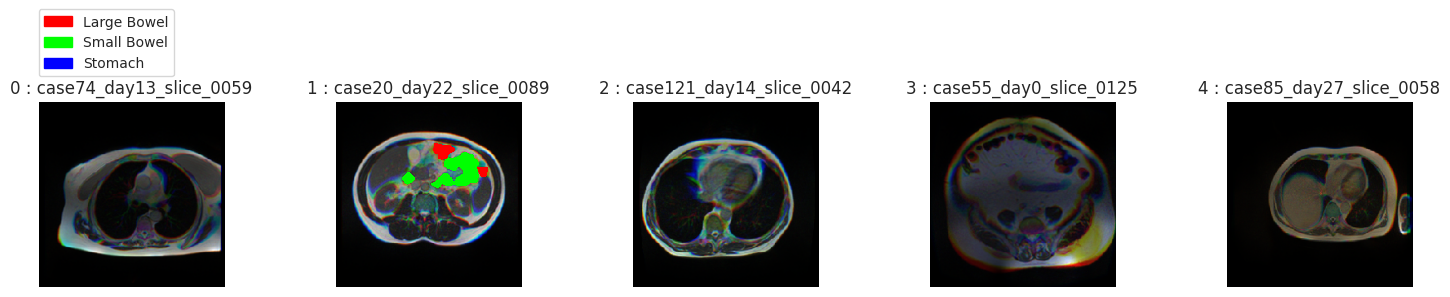

In [78]:
display_dataset(dataset, num_images=5, denormalize=True)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
['case74_day13_slice_0059', 'case20_day22_slice_0089', 'case121_day14_slice_0042', 'case55_day0_slice_0125', 'case85_day27_slice_0058']
(266, 266)
(266, 266)
(266, 266)
(266, 266)
(310, 360)


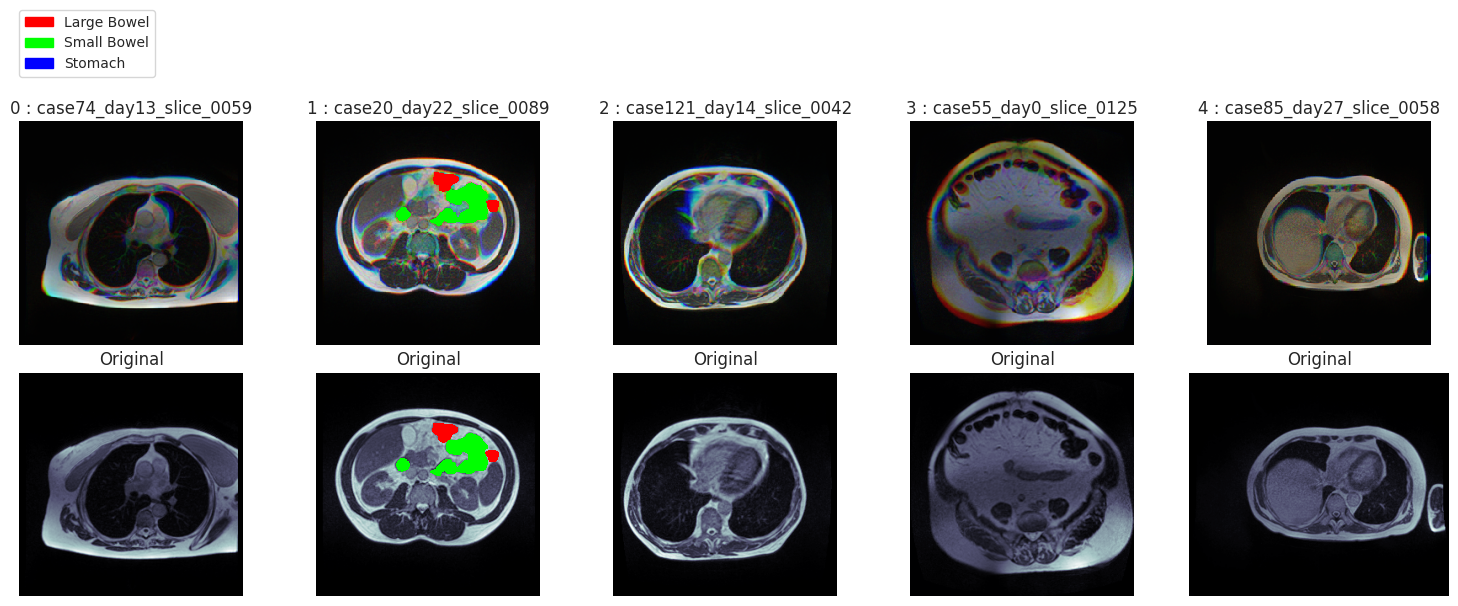

In [79]:
display_dataset(dataset, display_orig=True, denormalize=True, apply_CLAHE=True)

# Model

In [80]:
if TRAIN_VALID_SPLIT or TRAIN_ON_FULL_DATA or TEST_PREDICT:
	# https://smp.readthedocs.io/en/latest/encoders_timm.html
	smp_encoder_weights = None if TEST_PREDICT and LOAD_MODEL_FOR_TEST_PREDICT else 'imagenet'
	model = smp.Unet(
	    encoder_name = 'efficientnet-b1',        
	    encoder_weights = smp_encoder_weights,     
	    in_channels = 3,                  
	    classes = NUM_CLASSES,                      
	)
	model.to(DEVICE)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

# Optimizer

In [81]:
if TRAIN_VALID_SPLIT or TRAIN_ON_FULL_DATA or TEST_PREDICT:
    
    optimizer = optim.Adam(model.parameters(), lr = LR_START)

    #We use an LR scheduler that gives constant LR in first few epochs and then decreases with cosine decay
    const_scheduler = optim.lr_scheduler.LambdaLR(optimizer, 
                                                  lr_lambda = lambda epoch: 1.0)
    cosine_decay_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                                  T_max = EPOCHS - LR_CONSTANT_EPOCHS, 
                                                                  eta_min = LR_END)
    scheduler = optim.lr_scheduler.SequentialLR(optimizer, 
                                                schedulers = [const_scheduler, cosine_decay_scheduler], 
                                                milestones = [LR_CONSTANT_EPOCHS])
                                                                  
    
    scaler = GradScaler('cuda')

# Loss function

In [82]:
dice_loss = smp.losses.DiceLoss(mode='multilabel') 
BCE_loss = smp.losses.SoftBCEWithLogitsLoss()

def loss_fn(y_pred, y_true, loss_wt = 0.5):
    return dice_loss(y_pred, y_true) * loss_wt + BCE_loss(y_pred, y_true) * (1 - loss_wt)

# Metrics

## Dice Metric class

In [83]:
class DiceScoreCustom:
	def __init__(self, num_classes, eps=1e-6):
		self.num_classes = num_classes
		self.eps = eps
		self.reset()

	def reset(self):
		self.dice_sum = 0.0
		self.image_count = 0

		# per-organ totals
		self.organ_dice_sum = torch.zeros(self.num_classes)
		self.organ_count = torch.zeros(self.num_classes)

	def update(self, preds, targets):
		"""
		preds, targets: (B, C, H, W) binary {0,1} tensors
		Implements host comment: skip organs where both pred & target are empty : https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/324934
		"""
		I = (targets & preds).sum((2, 3))
		U = (targets | preds).sum((2, 3))

		# Dice per organ (B, C)
		dice = (2 * I) / (U + I + self.eps)

		# Mask out empty organs (where both pred and gt are 0)
		non_empty = U > 0  # (B, C)

		# For each image (B), compute mean over valid organs only
		organ_counts = non_empty.sum(dim=1)  # (B)
		dice_per_image = dice.sum(dim=1) / organ_counts.clamp(min=1)

		#note : accumulators below are moved to CPU to reduce GPU memory usage

		# accumulate global
		valid_images = organ_counts > 0
		if valid_images.any():
			self.dice_sum += dice_per_image[valid_images].sum().item()
			self.image_count += dice_per_image[valid_images].numel()

		# accumulate per-organ
		self.organ_dice_sum += dice.sum(dim=0).detach().cpu()
		self.organ_count += non_empty.sum(dim=0).detach().cpu()

	def compute(self):
		"""
		Returns:
			overall dice: scalar tensor
			per_organ dice: (C,) tensor
		"""
		overall = (
			torch.tensor(self.dice_sum / self.image_count)
			if self.image_count > 0 
			else torch.tensor(0.0)
		)
		per_organ = torch.where(
			self.organ_count > 0,
			self.organ_dice_sum / self.organ_count,
			torch.tensor(0.0)
		)
		return overall, per_organ

## Hausdorff distance class

In [84]:
class HausdorffDistanceCustom:
	def __init__(self, num_classes):
		self.num_classes = num_classes
		self.reset()

	def reset(self):
		self.h3d_sum = 0.0
		self.image3d_count = 0

		self.organ_h3d_sum = np.zeros(self.num_classes)
		self.organ_count_sum = np.zeros(self.num_classes)

	def _compute_hausdorff_per_organ(self, preds, targets):
		'''
		preds and targets : (Depth, Height, Width) binary {0,1} tensors
		'''
		if np.all(preds == targets):
			return 0.0
	
		(edges_preds, edges_targets) = get_mask_edges(preds, targets)
		surface_distance = get_surface_distance(edges_preds, edges_targets, distance_metric="euclidean")
	
		if surface_distance.shape == (0,):
			return 0.0
		dist = surface_distance.max()
		max_dist = np.sqrt(np.sum((np.array(preds.shape) - 1) ** 2))
	
		if dist > max_dist:
			return 1.0
	
		return dist / max_dist

	def update(self, preds, targets):
		'''
		preds and targets : (Channel, Depth, Height, Width) binary {0,1} tensors
		'''

		U = (targets | preds).sum((1, 2, 3))  # [C]

		hausdorff = np.array([self._compute_hausdorff_per_organ(preds[i, ...], targets[i, ...]) for i in range(NUM_CLASSES)])  # [C]

		# Mask out empty organs (where both pred and gt are 0)
		non_empty = U > 0  # [C]

		organ_count = non_empty.sum()

		if organ_count != 0:
			hausdorff_per_3dimage = hausdorff.sum() / organ_count

			# accumulate global
			self.h3d_sum += hausdorff_per_3dimage
			self.image3d_count += 1

		# accumulate per-organ
		self.organ_h3d_sum += hausdorff
		self.organ_count_sum += non_empty

	def compute(self):
		"""
		Returns:
			overall hausdorff: scalar
			per_organ hausdorff: (C,)
		"""
		overall = self.h3d_sum / self.image3d_count

		per_organ = self.organ_h3d_sum / self.organ_count_sum

		return overall, per_organ

In [85]:
dice_score_obj = DiceScoreCustom(num_classes=NUM_CLASSES)
hausdorff_obj = HausdorffDistanceCustom(num_classes=NUM_CLASSES)

# Training

In [86]:
def one_epoch_train(epoch, dataloader):

    epoch_start = time.time()
    
    model.train() #set model in training mode
    running_loss = 0.0

    data_time, gpu_times = 0.0, []
    data_end_time = time.time()  #used to compute data loading time
    
    loop = tqdm(dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for data in loop:

        data_time += time.time() - data_end_time
        
        imgs, masks, ids = data
        imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)

        start_event = torch.cuda.Event(enable_timing = True)
        end_event = torch.cuda.Event(enable_timing = True)
        start_event.record()
        
        optimizer.zero_grad()
        with autocast('cuda'):
            pred_masks = model(imgs)
            loss = loss_fn(pred_masks, masks)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        end_event.record()
        gpu_times.append((start_event, end_event))
        
        loop.set_postfix(loss=loss.item())

        data_end_time = time.time()

    torch.cuda.synchronize()
    gpu_time = sum(s.elapsed_time(e) for s,e in gpu_times) / 1000.0   #seconds

    avg_loss = running_loss / len(dataloader)

    epoch_time = time.time() - epoch_start

    time_log = {
        'epoch': epoch,
        't_epoch_time': epoch_time, #t for train
        't_data_time': data_time,
        't_gpu_time': gpu_time,
        't_data_perc': data_time * 100.0 / epoch_time,
        't_gpu_perc': gpu_time * 100.0 / epoch_time
    }
    
    return avg_loss, time_log

In [87]:
slices80_casedays = set(
    data_valid[['case', 'day', 'slice']]
    .drop_duplicates()
    .value_counts(['case', 'day'])
    .loc[lambda s: s == 80]
    .index
)
#slices80_casedays

In [88]:
def one_epoch_valid(epoch, dataloader):

    epoch_start = time.time()
    
    model.eval()

    data_time, gpu_times, hausdorff_time = 0.0, [], 0.0

    with torch.no_grad():
        running_loss = 0.0
        pred_masks_dict, masks_dict = {}, {}
        
        data_end_time = time.time()  #used to compute data loading time
        
        for data in dataloader:
            data_time += time.time() - data_end_time
            
            imgs, masks, ids = data
            imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)

            start_event = torch.cuda.Event(enable_timing = True)
            end_event = torch.cuda.Event(enable_timing = True)
            start_event.record()

            with autocast('cuda'):
                pred_masks = model(imgs)
                loss = loss_fn(pred_masks, masks)
            running_loss += loss.item()

            pred_masks = (torch.sigmoid(pred_masks.float()) > 0.5).int()   #pred_masks.float() to convert from FP16 to FP32
            masks = masks.int()
            dice_score_obj.update(pred_masks, masks)

            end_event.record()
            gpu_times.append((start_event, end_event))

            #loop through predictions and true masks to create 3D volume with all slices per caseday for Hausdorff computation
            hausdorff_start = time.time()
            for p, m, id_ in zip(pred_masks, masks, ids):
                match = re.match(r"case(\d+)_day(\d+)_slice_(\d+)", id_)
                if match:
                    caseid, dayid, sliceid = map(int, match.groups())

                casedayid = (caseid, dayid) 

                pred_masks_dict.setdefault(casedayid, []).append((sliceid, p))
                masks_dict.setdefault(casedayid, []).append((sliceid, m))

                #in the data, casedays have either 144 slices or 80 slices
                if (len(pred_masks_dict[casedayid]) == 144) or (casedayid in slices80_casedays and len(pred_masks_dict[casedayid]) == 80):
                    pred_masks_sorted = [p.cpu().numpy() for sid, p in sorted(pred_masks_dict[casedayid], key=lambda x: x[0])]
                    masks_sorted = [m.cpu().numpy() for sid, m in sorted(masks_dict[casedayid], key=lambda x: x[0])]

                    pred_masks_volume = np.stack(pred_masks_sorted, axis=1)
                    masks_volume = np.stack(masks_sorted, axis=1)

                    hausdorff_obj.update(pred_masks_volume, masks_volume)

                    #free memory
                    del pred_masks_dict[casedayid], masks_dict[casedayid]
            hausdorff_time += time.time() - hausdorff_start

            data_end_time = time.time()

            
        avg_loss = running_loss / len(dataloader)

        epoch_dice_score = dice_score_obj.compute()
        dice_score_obj.reset()
        
        epoch_hausdorff = hausdorff_obj.compute()
        hausdorff_obj.reset()   

    torch.cuda.synchronize()
    gpu_time = sum(s.elapsed_time(e) for s,e in gpu_times) / 1000.0   #seconds
    
    epoch_time = time.time() - epoch_start
    
    time_log = {
        'epoch': epoch,
        'v_epoch_time': epoch_time, #v for valid
        'v_data_time': data_time,
        'v_gpu_time': gpu_time,
        'v_hausdorff_time': hausdorff_time,
        'v_data_perc': data_time * 100.0 / epoch_time,
        'v_gpu_perc': gpu_time * 100.0 / epoch_time,
        'v_hausdorff_perc': hausdorff_time * 100.0 / epoch_time,
    }
        
    return avg_loss, epoch_dice_score, epoch_hausdorff, time_log
    

In [89]:
# Monitor resources
if TRAIN_VALID_SPLIT or TRAIN_ON_FULL_DATA:
    pynvml.nvmlInit()
    gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    
    stats_log = []
    stop_event = threading.Event()
    
    def monitor_resources(interval = 5):
        while not stop_event.is_set():
            gpu_util = pynvml.nvmlDeviceGetUtilizationRates(gpu_handle).gpu
            gpu_mem = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle).used / 1024**2
            cpu_util = psutil.cpu_percent(interval = None)
            cpu_mem = psutil.virtual_memory().used / 1024**2
            stats_log.append({
                'time': time.time(),
                'gpu_util': gpu_util,
                'gpu_mem_MB': gpu_mem,
                'cpu_util': cpu_util,
                'cpu_mem_MB': cpu_mem
            })
            time.sleep(interval)
    
    # Start monitoring
    thread = threading.Thread(target = monitor_resources)
    thread.start()

## Train with train-valid split

In [90]:
if TRAIN_VALID_SPLIT:
	time_logs_train, time_logs_valid, loss_metric_logs = [], [], []
	header = (
		f"{'Epoch':<5} | {'LR':<9} | "
		f"{'Train Loss':<10} | {'Valid Loss':<10} | {'Combined Metric':<15} | "
		f"{'Dice Overall':<12} | {'Hausdorff Overall':<17} | "
		f"{'D-LB':<6} {'D-SB':<6} {'D-S':<6} | "
		f"{'H-LB':<6} {'H-SB':<6} {'H-S':<6}"
	)
	print(header)
	loss_metric_logs.append(header)
	loss_metric_logs.append('-' * len(header))

	for epoch in range(EPOCHS):
		scheduler.step() #calling step at the start so that the LR_END value will be used in the last epoch 

		#recreating caseday_replay_transform to get new frozen transforms for new epoch
		#recreating dataset and dataloader to start using the updated caseday_replay_transform
		caseday_replay_transform = create_caseday_replay_transform(data_train, transform_train)
		dataset_train = GITractDataset(data_train, dataset_type='train', transforms=transform_train)
		dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE_TRAIN, shuffle=True, 
									  num_workers=DATA_LOADER_NUM_WORKERS, pin_memory=True)
		
		loss_train, time_log_train = one_epoch_train(epoch, dataloader_train)
		del caseday_replay_transform, dataset_train, dataloader_train
		gc.collect()
		
		loss_valid, dice_score, hausdorff, time_log_valid = one_epoch_valid(epoch, dataloader_valid)
		
		dice_overall, dice_per_organ = dice_score
		hausdorff_overall, hausdorff_per_organ = hausdorff
		combined_metric = 0.4*dice_overall + 0.6*(1-hausdorff_overall)

		loss_metric_log = (
			f"{epoch+1:<5} | {optimizer.param_groups[0]['lr']:<9.6f} | "
			f"{loss_train:<10.3f} | {loss_valid:<10.3f} | {combined_metric:<15.3f} | "
			f"{dice_overall:<12.3f} | {hausdorff_overall:<17.3f} | "
			f"{dice_per_organ[0]:<6.3f} {dice_per_organ[1]:<6.3f} {dice_per_organ[2]:<6.3f} | "
			f"{hausdorff_per_organ[0]:<6.3f} {hausdorff_per_organ[1]:<6.3f} {hausdorff_per_organ[2]:<6.3f}"
		)
		
		print(loss_metric_log)

		time_logs_train.append(time_log_train)
		time_logs_valid.append(time_log_valid)
		loss_metric_logs.append(loss_metric_log)

	print('\n'.join(loss_metric_logs))

	time_logs_df = pd.merge(
						pd.DataFrame(time_logs_train),
						pd.DataFrame(time_logs_valid),
						on = 'epoch', how = 'inner'
				   )[[
						'epoch', 
						't_epoch_time', 'v_epoch_time', 
						't_data_time', 'v_data_time', 
						't_gpu_time', 'v_gpu_time',
						'v_hausdorff_time',
						't_data_perc', 'v_data_perc', 
						't_gpu_perc', 'v_gpu_perc',
						'v_hausdorff_perc'
					]]
	display(time_logs_df)

Epoch | LR        | Train Loss | Valid Loss | Combined Metric | Dice Overall | Hausdorff Overall | D-LB   D-SB   D-S    | H-LB   H-SB   H-S   


Epoch 1/10:   0%|          | 0/467 [00:00<?, ?it/s]

1     | 0.000500  | 0.295      | 0.161      | 0.783           | 0.585        | 0.086             | 0.654  0.506  0.603  | 0.092  0.093  0.074 


Epoch 2/10:   0%|          | 0/467 [00:00<?, ?it/s]

2     | 0.000500  | 0.097      | 0.136      | 0.810           | 0.644        | 0.079             | 0.695  0.565  0.695  | 0.079  0.078  0.079 


Epoch 3/10:   0%|          | 0/467 [00:00<?, ?it/s]

3     | 0.000500  | 0.081      | 0.136      | 0.811           | 0.645        | 0.078             | 0.691  0.575  0.687  | 0.106  0.069  0.059 


Epoch 4/10:   0%|          | 0/467 [00:00<?, ?it/s]

4     | 0.000478  | 0.072      | 0.129      | 0.818           | 0.651        | 0.071             | 0.707  0.583  0.677  | 0.076  0.076  0.061 


Epoch 5/10:   0%|          | 0/467 [00:00<?, ?it/s]

5     | 0.000415  | 0.066      | 0.130      | 0.817           | 0.645        | 0.068             | 0.698  0.575  0.703  | 0.070  0.073  0.060 


Epoch 6/10:   0%|          | 0/467 [00:00<?, ?it/s]

6     | 0.000325  | 0.061      | 0.129      | 0.813           | 0.649        | 0.078             | 0.701  0.580  0.693  | 0.092  0.086  0.057 


Epoch 7/10:   0%|          | 0/467 [00:00<?, ?it/s]

7     | 0.000225  | 0.057      | 0.126      | 0.812           | 0.655        | 0.084             | 0.716  0.595  0.686  | 0.090  0.079  0.081 


Epoch 8/10:   0%|          | 0/467 [00:00<?, ?it/s]

8     | 0.000135  | 0.052      | 0.126      | 0.816           | 0.654        | 0.076             | 0.713  0.585  0.695  | 0.090  0.083  0.054 


Epoch 9/10:   0%|          | 0/467 [00:00<?, ?it/s]

9     | 0.000072  | 0.050      | 0.126      | 0.818           | 0.656        | 0.074             | 0.712  0.582  0.703  | 0.084  0.090  0.049 


Epoch 10/10:   0%|          | 0/467 [00:00<?, ?it/s]

10    | 0.000050  | 0.048      | 0.126      | 0.824           | 0.662        | 0.068             | 0.716  0.589  0.704  | 0.085  0.074  0.045 
Epoch | LR        | Train Loss | Valid Loss | Combined Metric | Dice Overall | Hausdorff Overall | D-LB   D-SB   D-S    | H-LB   H-SB   H-S   
----------------------------------------------------------------------------------------------------------------------------------------------
1     | 0.000500  | 0.295      | 0.161      | 0.783           | 0.585        | 0.086             | 0.654  0.506  0.603  | 0.092  0.093  0.074 
2     | 0.000500  | 0.097      | 0.136      | 0.810           | 0.644        | 0.079             | 0.695  0.565  0.695  | 0.079  0.078  0.079 
3     | 0.000500  | 0.081      | 0.136      | 0.811           | 0.645        | 0.078             | 0.691  0.575  0.687  | 0.106  0.069  0.059 
4     | 0.000478  | 0.072      | 0.129      | 0.818           | 0.651        | 0.071             | 0.707  0.583  0.677  | 0.076  0.076  0.061 

epoch  t_epoch_time  v_epoch_time  t_data_time  v_data_time  t_gpu_time  \
0      0    233.982565     64.402816     3.226686     3.039078  213.485835   
1      1    227.862495     59.492215     1.442609     1.489231  211.693773   
2      2    221.066860     60.079659     1.511311     1.524688  211.540872   
3      3    221.326890     58.880811     1.705675     1.612660  211.496813   
4      4    230.089025     58.870951     1.430998     1.725219  211.510748   
5      5    230.720224     60.783530     1.484328     1.666314  211.672119   
6      6    221.420732     60.728491     1.574519     1.535203  211.754254   
7      7    221.801028     61.102171     1.792733     1.622830  211.883622   
8      8    222.000582     60.173597     1.489316     1.673537  212.059657   
9      9    222.301941     59.457575     1.970349     1.550966  211.996442   

   v_gpu_time  v_hausdorff_time  t_data_perc  v_data_perc  t_gpu_perc  \
0   14.647719         41.808094     1.379028     4.718860   91.240061   
1   14.230354         38.861289     0.633105     2.503237   92.904176   
2   14.228491         39.405175     0.683644     2.537777   95.690902   
3   14.226959         38.182143     0.770659     2.738856   95.558571   
4   14.230957         38.025481     0.621932     2.930511   91.925614   
5   14.231594         39.983481     0.643345     2.741391   91.744068   
6   14.232118         40.102684     0.711098     2.527978   95.634339   
7   14.251516         40.165076     0.808262     2.655928   95.528692   
8   14.252840         39.165477     0.670861     2.781181   95.522117   
9   14.254525         38.519792     0.886339     2.608526   95.364188   

   v_gpu_perc  v_hausdorff_perc  
0   22.743911         64.916561  
1   23.919691         65.321638  
2   23.682709         65.588213  
3   24.162301         64.846495  
4   24.173140         64.591246  
5   23.413569         65.780123  
6   23.435652         66.036029  
7   23.324074         65.734287  
8   23.686202         65.087478  
9   23.974279         64.785340

## Train on full data

In [91]:
if TRAIN_ON_FULL_DATA:
	time_logs_train, loss_logs = [], []
	header = (
		f"{'Epoch':<5} | {'LR':<9} | {'Train Loss':<10}"
	)
	print(header)
	loss_logs.append(header)
	loss_logs.append('-' * len(header))

	for epoch in range(EPOCHS):
		scheduler.step()
		
		caseday_replay_transform = create_caseday_replay_transform(data, transform_train)
		dataset_train_full = GITractDataset(data, dataset_type='train', transforms=transform_train)
		dataloader_train_full = DataLoader(dataset_train_full, batch_size=BATCH_SIZE_TRAIN, shuffle=True,
										   num_workers=DATA_LOADER_NUM_WORKERS, pin_memory=True)
		
		loss_train, time_log_train = one_epoch_train(epoch, dataloader_train_full)
		del caseday_replay_transform, dataset_train_full, dataloader_train_full
		gc.collect()

		loss_log = (
			f"{epoch+1:<5} | {optimizer.param_groups[0]['lr']:<9.6f} | {loss_train:<10.3f}"
		)
		print(loss_log)

		time_logs_train.append(time_log_train)
		loss_logs.append(loss_log)

	print('\n'.join(loss_logs))

	time_logs_df = pd.DataFrame(time_logs_train)
	display(time_logs_df)

In [92]:
if TRAIN_VALID_SPLIT or TRAIN_ON_FULL_DATA:
    stop_event.set()
    thread.join()

    df_stats = pd.DataFrame(stats_log)
    display(df_stats.describe())  # summary stats

time    gpu_util   gpu_mem_MB    cpu_util   cpu_mem_MB
count  5.740000e+02  574.000000   574.000000  574.000000   574.000000
mean   1.760456e+09   77.559233  9655.655488   47.904704  3908.372911
std    8.296499e+02   34.837932   504.793252    5.329083   596.191040
min    1.760455e+09    0.000000   410.875000    0.000000  1993.429688
25%    1.760455e+09   77.000000  9768.875000   45.600000  3647.589844
50%    1.760456e+09   93.000000  9768.875000   46.500000  3873.570312
75%    1.760457e+09   99.000000  9768.875000   49.775000  3926.627930
max    1.760458e+09  100.000000  9768.875000   72.500000  5767.093750

In [93]:
if TRAIN_VALID_SPLIT and SAVE_TRAIN_VALID_MODEL:
    torch.save(model.state_dict(), MODEL_PARAMS_FILE_NAME)

In [94]:
if TRAIN_ON_FULL_DATA and SAVE_FULL_DATA_MODEL:
    torch.save(model.state_dict(), MODEL_PARAMS_FULL_DATA_FILE_NAME)

# Predict on test data

In [95]:
if TEST_PREDICT: 
    if LOAD_MODEL_FOR_TEST_PREDICT:
        model.load_state_dict(torch.load(MODEL_PARAMS_LOAD_FILE_PATH))
    model.eval()

    data_test = pd.read_csv(DIR_PATH + "sample_submission.csv")
    test_set_hidden = not bool(len(data_test))
    if test_set_hidden:
        data_test = data_valid  # Use validation data for testing the code prior to submission
    else:
        data_test[['case', 'day', 'slice']] = data_test['id'].str.extract(r'case(\d+)_day(\d+)_slice_(\d+)')
        path_df = get_path_df(train = False)

        data_test = data_test.merge(path_df, on = ['case', 'day', 'slice'])
    
        int_cols = ['case', 'day', 'slice', 'slice_w', 'slice_h']
        data_test[int_cols] = data_test[int_cols].astype(np.uint32)
    
        float_cols = ['px_w', 'px_h']
        data_test[float_cols] = data_test[float_cols].astype(np.float32)

    transform_test = A.Compose([
        A.Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1], interpolation=cv2.INTER_NEAREST),
        A.Normalize(mean=IMAGE_NORMALIZE_MEAN, std=IMAGE_NORMALIZE_SD, max_pixel_value=1.0),
        A.ToTensorV2(transpose_mask = False),
    ])    
    dataset_test = GITractDataset(data_test, dataset_type='test', transforms=transform_test, load_resized=False)
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE_TEST, shuffle=False, num_workers=DATA_LOADER_NUM_WORKERS)

In [96]:
if TEST_PREDICT:
    test_ids, test_class, test_pred_RLE = [], [], []   # data to be written to submission file
    
    with torch.no_grad():
        for imgs, ids, heights, widths in dataloader_test:
            imgs = imgs.to(DEVICE, dtype=torch.float)
            with autocast('cuda'):
                pred_masks = model(imgs)
            pred_masks = (torch.sigmoid(pred_masks.float()) > 0.5).int()
            pred_masks = pred_masks.permute(0, 2, 3, 1).cpu().numpy()   # shape after permute [B, H, W, C]

            for mask, id_, h, w in zip(pred_masks, ids, heights, widths):
                mask_orig_size = cv2.resize(mask, dsize=(w.item(), h.item()), interpolation=cv2.INTER_NEAREST)
                rles = [rle_encode(mask_orig_size[..., chid]) for chid in range(NUM_CLASSES)]
                
                test_ids.extend([id_] * NUM_CLASSES)
                test_class.extend(CLASS_NAMES)
                test_pred_RLE.extend(rles)

    submission_df = pd.DataFrame({
        'id': test_ids, 
        'class': test_class, 
        'predicted': test_pred_RLE
    })
    submission_df.to_csv('submission.csv', index=False)
    !head submission.csv
    display(submission_df.loc[submission_df.predicted != ""].head())

# References
* https://www.kaggle.com/code/awsaf49/uwmgi-mask-data
* https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode
* https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch
* https://www.kaggle.com/code/andradaolteanu/aw-madison-eda-in-depth-mask-exploration
* https://www.kaggle.com/code/masatomurakawamm/uwmgi-pspnet-u-net-deeplabv3-swin-unet
* https://www.kaggle.com/code/clemchris/gi-seg-pytorch-train-infer : for metrics
* https://www.kaggle.com/code/carnozhao/tract-competiton-metrics/notebook : for metrics
* https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/324432 : metrics
* https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/324934 : mentions that "when mask and pred are 0, not included in metric"
* https://www.kaggle.com/code/yiheng/50-times-faster-way-get-hausdorff-with-monai